# Intro

Hugging Face provides three ways to fine-tune a pretrained text classification model: Tensorflow Keras, PyTorch, and transformer trainer. Transformer trainer is an API for feature-complete training in PyTorch without writing all the loops. This notebook will use the transformer trainer to fine-tune a text classification model. We will talk about the following:
* How does transfer learning work?
* How to convert a pandas dataframe into a Hugging Face Dataset?
* How to tokenize text, load a pretrained model, set training arguments, and train a transfer learning model?
* How to make predictions and evaluate the model performance of a fine-tuned transfer learning model for text classification?
* How to save the model and re-load the model?

*Resources*:
- [Customized Sentiment Analysis: Transfer Learning Using Tensorflow with Hugging Face](https://medium.com/grabngoinfo/customized-sentiment-analysis-transfer-learning-using-tensorflow-with-hugging-face-1b439eedf167).
- [NLP Transfer Learning Tutorials](https://www.youtube.com/playlist?list=PLVppujud2yJpx5r8GFeJ81fyek8dEDMX-)
- [How to fine-tune a model on text classification](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb)

**Transfer Learning Algorithms**

Transfer learning is a machine learning technique that reuses a pretrained large deep learning model on a new task. It usually includes the following steps:
1. Select a pretrained model that is suitable for the new task. For example, if the new task includes text from different languages, a multi-language pretrained model needs to be selected.
2. **Keep all the weights and biases from the pretrained model except for the output layer.** This is because the output layer for the pretrained model is for the pretrained tasks and it needs to be replaced with the new task.
3. Feed randomly initialize weights and biases into the new head of the new task. In the example of sentiment analysis transfer learning (aka fine-tuning) model on a pretrained BERT model, we will remove the head that classifies mask words, and replace it with the two sentiment analysis labels, positive and negative. 
4. Retrain the model for the new task with the new data, utilizing the pretrained weights and biases. Because the weights and biases store the knowledge learned from the pretrained model, the fine-tuned transfer learning model can build on that knowledge and does not need to learn from scratch.

## 1. Set-up

In [1]:
!pip install -U transformers datasets evaluate
!pip install emoji unidecode pattern -q
!pip install optuna 
!pip install ray[tune]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Copy datasets from Google Drive To Local VM to Avoid Disconnection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r /content/data
!cp -r /content/drive/MyDrive/nlp/zindi/data /content

rm: cannot remove '/content/data': No such file or directory


Load Python Libraries

In [4]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import *

# language modeling
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

# hypertune
import optuna

# text wragling
import re, string
from bs4 import BeautifulSoup
import emoji

# other libraries
import os, gc, tqdm, datetime, random

# customize printing
import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', None)

Environment Variables

In [5]:
seed = 128

TRAIN_DATA_PATH = '/content/data/Train.csv'
TEST_DATA_PATH = '/content/data/Test.csv'
SAMPLE_SUB_PATH = '/content/data/SampleSubmission.csv'

TIMESTAMP = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(TIMESTAMP)

MODEL_SPEC = 'roberta-large'

20230417-065727


Define Utility Functions

In [6]:
def make_predictions(dataset_test, trainer, df_test):
  # make predictions
  y_pred_dict = trainer.predict(dataset_test)

  # extract predicted values
  y_pred = y_pred_dict.predictions
  y_pred = np.clip(y_pred, -1, 1)
  df_y_pred = pd.DataFrame({'tweet_id':df_test.tweet_id,'score':y_pred.ravel()})

  # validation to make sure predictions are not off
  assert len(df_y_pred) == len(sample_sub), "number of instances in test set doesn't align with sample submission."
  assert len(df_y_pred[df_y_pred['score']==0]) < 1, "number of 0 predictions exist. model configuration is wrong."
  print(df_y_pred['score'].describe())
  plt.hist(df_y_pred['score'], bins=30)
  plt.show()

  return df_y_pred

Import Datasets

In [7]:
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

In [8]:
print('-'*10,'train','-'*10)
train.info()
train.sample(10)
print('-'*10,'test','-'*10)
test.info()
test.sample(10)
print('-'*10, 'sample submission', '-'*10)
sample_sub.info()
sample_sub.head(3)

---------- train ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


,tweet_id,safe_text,label,agreement
1824,G41KC2SD,Vaccinate your damn kids . Hell to you Jenny McCarthy <url>,1.0,1.000000
1756,O7ML7EUD,So great to meet <user> and feel her amazing energy for children and families! #vaccineswork #protectthefuture <url>,1.0,0.666667
459,3AM7OQA9,The #measles killed me multiple times on the Oregon Trail game back in elementary school. So did dysentery.,0.0,1.000000
9693,LAWD65Q2,<user> #Mmr final location<user>\n<url>,0.0,0.666667
9420,4WQ86R6K,<user> Risk/reward fully compensates for any qualms of vaccination.,1.0,0.666667
3844,ZOLHJP23,“<user> This dude probably didn’t get his kids vaccinated either \n<url> #nipples,0.0,0.666667
409,GWUOU01D,Waiting with an elderly woman and mentally disabled kids at bus stop in Padadena. Woman: this is caused by corrupt gov and vaccination WTF?,0.0,0.666667
8893,A4UI57JB,"<user> The BCG (TB vaccine) isn't given in the US, I don't want my kids in school being exposed to disease YOU take that risk yourself",1.0,1.000000
5780,5YE3PZWR,<user> <user> right! Like if it were true a lot more kids would have it and I'm sure those vaccines would no longer exist.,1.0,0.666667
8015,B3YBNF57,Health Experts: Flu Vaccine Is Not A Failsafe This Year: The flu shot you received may not protect you from getting… <url>,0.0,0.666667


---------- test ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


,tweet_id,safe_text
677,4LQRXBEX,<user> Whoa. New strain or did parents not vaccinate their kids?
974,6MU3AQLA,San Diego Supervisors Vote To Stop Routine Immunization Services For Kids: San Diego County officials said most… <url>
2966,KIRP7W8P,<user> CNN &amp; Brown &amp; Garner Crowd Trying To Diminish Public Trust &amp; Safety By Claiming Criminals Need To Trust Immunity From police Action
1601,AZXRLNKW,"""<user> RT <user> <url> vaccines""WTF"
1002,6T8L3MYH,Disneyland measles outbreak isn't largest in recent memory <url>
3741,PT81EM0M,"""<user> On average, people who complain live longer --Releasing this tension increases immunity and boosts their health."""
2535,HKP73GRQ,Killing young healthcare workers in Pakistan for distributing polio vaccines to children. Shameful.
2852,JS4JCHNP,<user> how do I avoid endangering my child thru vaccinations w/o CPS accusing me of child endangerment and stealing my kids?
1092,7ICYUWS7,Call and Request at <user> Build A Bihh @ Local Station...... #BuildABihh #FreeLunch #MMR… <url>
2961,KI132IAJ,Rand Paul Was Longtime Member Of Group That Promoted Autism-Vaccines Link <url> <user> just like dad\n#Tinfoilhatclub


---------- sample submission ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  5177 non-null   object
 1   label     5177 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.0+ KB


,tweet_id,label
0,00BHHHP1,0
1,00UNMD0E,0
2,01AXPTJF,0


In [9]:
# check data imbalance
pd.DataFrame({'num_of_instances':train.label.value_counts(dropna=False), 
              '%':train.label.value_counts(normalize=True,dropna=False)})

,num_of_instances,%
0.000000,4908,0.490751
1.000000,4053,0.405259
-1.000000,1038,0.103790
NaN,1,0.000100
0.666667,1,0.000100


In [10]:
pd.DataFrame({'num_of_instances':train.agreement.value_counts(dropna=False),
              '%':train.agreement.value_counts(normalize=True,dropna=False)})

,num_of_instances,%
1.000000,5866,0.586541
0.666667,3894,0.389361
0.333333,239,0.023898
NaN,2,0.000200


In [11]:
# check missisng values
train.isnull().sum()
train[train.isnull().any(axis=1)]

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

,tweet_id,safe_text,label,agreement
4798,RQMQ0L2A,#lawandorderSVU,NaN,NaN
4799,I cannot believe in this day and age some parents could be so oblivious to reality as to not #vaccinate their child.,1,0.666667,NaN


In [12]:
test.isnull().sum()
test[test.isnull().any(axis=1)]

tweet_id     0
safe_text    1
dtype: int64

,tweet_id,safe_text
2024,Dr. JAMES SHANNON,NaN


In [13]:
# make sure all tweet_id in test file shows up in sample submission file
test[~test['tweet_id'].isin(sample_sub['tweet_id'])]
sample_sub[~sample_sub['tweet_id'].isin(test['tweet_id'])]

,tweet_id,safe_text
2024,Dr. JAMES SHANNON,NaN


,tweet_id,label
2452,H0VUUY2P,0


## 1. Data Cleaning
- [X] Remove NaN rows
- [X] Because some of the tweets were annotated multiple times by the same annotator, there can be duplicated rows. 
  - We first need to drop all rows, but one, with duplicated tweets where HandLabel is the same. 
  - After that we drop all duplicated tweets, since they all have different HandLabel and we do not know which one is correct. It would have been wrong if we dropped all the duplicates at once, without looking at the HandLabel, because we would threw away the highest quality data (the tweets which were labeled same multiple times).
- [x] All tweets are converted to lowercase
- [X] All links were removed since they do not contain any relevant information for this task and also '[video]' and '{link}' strings were removed because Twitter sometimes converts links to to these keywords.
- [X] A lot of tweets are usually retweets, that means that they contain 'RT @tweet_user' keywords, since 'RT @' is of no use it is replaces by '@'. ('@' is kept as indicator of tweet_user, because we will be removing them in the following steps). 
- [X] All usernames are removed. Usernames are words that start with '@'.
- [X] Dealing with hashtags: Hashtag symbol '#' is removed, but the words that follow that symbol are kept, since they usually contain a lot of useful information (they are usualy compressed representation of the tweet)



*Reference*:
- [Top 2 PyTorch + SimpleTransformers Solutions](https://github.com/rajat5ranjan/Zindi-Solutions/blob/master/To%20Vaccinate%20or%20Not%20to%20Vaccinate%20%23ZindiWeekendz/final_sub.ipynb)
- [Twitter-Sentiment-Analysis-RoBERTa](https://github.com/Data-Science-kosta/Twitter-Sentiment-Analysis-RoBERTa)
- [Twitter Sentiment Analysis with BERT + RoBERTa](https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta)
- [Pre-Processing Tweets for Sentiment Analysis](https://medium.com/analytics-vidhya/pre-processing-tweets-for-sentiment-analysis-a74deda9993e)

In [14]:
train_clean = train.copy()
test_clean = test.copy()

### a. Missing values treatment

In [15]:
# training set
train_clean.iloc[4799,:] = ['MADEUPID', 'I cannot believe in this day and age some parents could be so oblivious to reality as to not #vaccinate their child.', 1.0, 0.666667]
train_clean.drop(index=[4798], inplace=True)
train_clean = train_clean[train_clean['label'].isin([-1.0, 0.0, 1.0])]
train_clean.reset_index(drop=True, inplace=True)

In [16]:
# test set
test_clean['safe_text'] = test_clean['safe_text'].fillna('Dr. JAMES SHANNON')
test_clean['tweet_id'] = np.where(test_clean['tweet_id']=='Dr. JAMES SHANNON', 'H0VUUY2P', test_clean['tweet_id'])

In [17]:
# audit - no missing values in both training and test sets
train_clean.isnull().sum()
test_clean.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

tweet_id     0
safe_text    0
dtype: int64

### b. Check Duplicates

In [18]:
def remove_dups(df, dataset = 'train'):
  '''
  This function removes duplicates by take two steps approach:
    step 1 We first need to drop all rows, but one, with duplicated tweets where label is the same.
    step 2 After that we drop all duplicated tweets, since they all have different label and we do not know which one is correct. 
  '''
  clean_df = df.copy()
  n_rows = len(clean_df)

  if dataset == 'train':
    # step 1 - drop duplicated tweets with same label
    clean_df = clean_df.drop_duplicates(subset=['safe_text','label'], keep='first')
    print(f'Dropped {n_rows - len(clean_df)} duplicate rows with same label')

    # step 2 - there are only duplicates with different hand label, so drop both of them
    n_rows = len(clean_df)
    clean_df = clean_df.drop_duplicates(subset=['safe_text'], keep=False)
    print(f'Dropped {n_rows - len(clean_df)} duplicate rows with different labels')

    # make sure no duplicates
    assert clean_df['safe_text'].nunique() == clean_df.shape[0], 'duplicates still exist'
    
  print("Length of clean {} set is {}".format(dataset, len(clean_df)))  
  return clean_df

In [19]:
train_clean = remove_dups(train_clean, 'train')
test_clean = remove_dups(test_clean, 'test')

Dropped 307 duplicate rows with same label
Dropped 72 duplicate rows with different labels
Length of clean train set is 9621
Length of clean test set is 5177


In [20]:
# understand text statistics - text length
train_clean['safe_text'].apply(lambda x: len(x)).describe()
print('\n')
test_clean['safe_text'].apply(lambda x: len(x)).describe()

count    9621.000000
mean      100.176697
std        29.813909
min         3.000000
25%        80.000000
50%       107.000000
75%       122.000000
max       153.000000
Name: safe_text, dtype: float64

count    5177.000000
mean       99.506471
std        29.994068
min         6.000000
25%        80.000000
50%       106.000000
75%       122.000000
max       151.000000
Name: safe_text, dtype: float64

### c. Tweets Text Data Cleaning

In [21]:
def preprocess_tweets(df, params):
  clean_df = df.copy()

  #----------
  # define helper functions
  #----------
  # [Y] recommend to include
  def remove_user_mentions(clean_df):
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.compile('rt @').sub('@', x).strip())      # substitute 'RT @' with '@'
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.sub('\@[ a-zA-Z0-9]*', '', x))            # Remove usernames. The usernames are any word that starts with @.
    return clean_df

  def remove_extra_white_space(clean_df):
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.strip('.').strip())
    return clean_df

 # [tentative] 
  def remove_tweet_special_chars(clean_df):
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace('#', ' '))
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace('\r', ' '))
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace('\n', ' ')) # BERT may USE \r \n as sentence delimiters
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace('&amp;', ' '))
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace('_', ' '))
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: x.replace(':', ' '))
    return clean_df

  # [NO] recommend not include
  def remove_numbers(clean_df):
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x:re.sub(r'\d+', '', x).strip())
    return clean_df

  def remove_punctuation(clean_df):
    pattern = r'[^\w\s]' 
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.sub(pattern,'', x))
    clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    return clean_df

  def replace_weird_chars(clean_df):
    from unidecode import unidecode
    clean_df['safe_text'] = clean_df['safe_text'].apply(unidecode)
    #clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x)) # [not working, maybe related to emoji] remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    return clean_df
  
  def url_to_words(raw_text):
    raw_text=str(raw_text).strip()
    soup = BeautifulSoup(raw_text, 'html.parser')
    raw_text = soup.text
    raw_text = emoji.demojize(raw_text)
    no_coms=re.sub(r'\.com','',raw_text)
    no_urls=re.sub('https?://www','',no_coms)
    no_urls1=re.sub('https?://','',no_urls)
    try:
        no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        no_encoding = no_urls1
    # letters_only = re.sub("[^a-zA-Z0-9]", " ",no_encoding) 
    words = no_encoding.lower().split()                             
    # stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words] 
    return( " ".join( meaningful_words ))

  def process_eng_hashtag(input_text: str) -> str:
    return re.sub(r'#[a-z|A-Z]\S*',lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*', m.group().lstrip('#'))), input_text)

  def lowercase(clean_df):
    clean_df['safe_text'] = clean_df['safe_text'].apply(str.lower)
    return clean_df

  def remove_patterns(df):
    #clean_df['safe_text'] = clean_df['safe_text'].str.replace('<user>|<url>|url|user|https?://\S+|www\.\S+|#\w+', '', regex=True)
    clean_df['safe_text'] = clean_df['safe_text'].str.replace('<user>|<url>', ' ', regex=True)
    return clean_df
  
  #----------
  # data preprocessing
  #----------
  # [yes] remove user mentions
  if params.get('remove_user_mentions', False): clean_df = remove_user_mentions(clean_df) 

  # [yes] remove extra space
  if params.get('remove_extra_space', False): clean_df = remove_extra_white_space(clean_df)

  # [no] convert url to words
  if params.get('url_to_words', False): clean_df['safe_text'] = clean_df['safe_text'].apply(url_to_words)

  # [no] split hashtag - has limitation on ALLCAPITALIZED words
  if params.get('process_eng_hashtag', False): clean_df['safe_text'] = clean_df['safe_text'].apply(lambda x: process_eng_hashtag(x))

  # [no] remove weird characters
  if params.get('replace_weird_chars', False): clean_df = replace_weird_chars(clean_df)

  # [no] remove numbers
  if params.get('remove_numbers', False): clean_df = remove_numbers(clean_df)

  # [no] remove punctuation
  if params.get('remove_punctuation', False): clean_df = remove_punctuation(clean_df)

  # [no for uncased model] convert to lowercase
  if params.get('lowercase', False): clean_df = lowercase(clean_df) 

  # [tentative] remove_tweet_special_chars
  if params.get('remove_tweet_special_chars', False): clean_df = remove_tweet_special_chars(clean_df) 

  # [good to keep] remove repeated patterns in tweets, such as <url>, <user>
  if params.get('remove_patterns', False): clean_df = remove_patterns(clean_df)

  return clean_df

In [22]:
params_preprocess = {
                     'remove_user_mentions':False,  # [YES]no.1 Boost performance, I'd like to keep. model does not analyze user name
                     'remove_extra_space':False,    # [YES]no.2 Boost performance, I'd like to keep
                     'remove_tweet_special_chars':False, # [TENTATIVE YES]no.3 boost performance, but cannot combine with remove_user_mentions
                     'lowercase':False,             # [NO] depends on models, tokenizer can take care of it
                     'remove_patterns':False,       # [NO] worse than do nothing, 0.50
                     'url_to_words':False,          # [NO] worse than do nothing
                     'split_hashtags':False,        # [NO] worse than do nothing. BERT can take care of hashtag based on internet discussion 
                     'replace_weird_chars':False,   # [NO] if apply unicode, not as good as do nothing; if remove non-acsii chars, even worse. [do not include]
                     'remove_numbers':False,        # [NO] worse than do nothing 
                     'remove_punctuation':False,    # [NO] worse than do nothing
                     }

In [23]:
train_clean = preprocess_tweets(train_clean, params_preprocess)
test_clean = preprocess_tweets(test_clean, params_preprocess)

In [24]:
# audit
from google.colab import data_table
data_table.enable_dataframe_formatter()

train_clean
test_clean

Output hidden; open in https://colab.research.google.com to view.

### d. Train/Validation/Test Split

In [25]:
def extract_text_and_y(df_train, df_test):

    # Training - This extraces the Train datasentece columns and pushes into variable text and one hot encodes the labels
    X_train_all = df_train['safe_text'].apply(str)
    y_train_all = df_train['label']

    #Test - This extracts the Test datasentence columns and pushes to a text
    X_test = df_test['safe_text'].apply(str)

    return X_train_all, y_train_all, X_test

In [26]:
X_train_all, y_train_all, X_test = extract_text_and_y(train_clean, test_clean)

# audit
print(len(X_train_all))
print(len(X_test))

9621
5177


In [27]:
# train validation split
def split_data(X_train_all, y_train_all, test_size, seed=seed):
  X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, 
                                                    test_size=test_size,
                                                    stratify=y_train_all, 
                                                    random_state=seed)
  print('number of instances in training set:{}'.format(len(X_train)))
  print('number of instances in validation set:{}'.format(len(X_val)))
  return X_train, X_val, y_train, y_val

In [30]:
X_train, X_val, y_train, y_val = split_data(X_train_all, y_train_all, test_size=0.125)

number of instances in training set:8418
number of instances in validation set:1203


In [31]:
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.DataFrame({'safe_text':X_test})

### e.Convert Pandas Dataframe to Hugging Face Dataset

Hugging Face Dataset objects are memory-mapped on drive, so they are not limited by RAM memory, which is very helpful for processing large datasets. We use `Dataset.from_pandas` to convert a pandas dataframe to a Hugging Face Dataset.

In [32]:
hg_train_data = Dataset.from_pandas(df_train)
hg_valid_data = Dataset.from_pandas(df_val)
hg_test_data = Dataset.from_pandas(df_test)

The length of the Hugging Face Dataset is the same as the number of records in the pandas dataframe. For example, there are 800 records in the pandas dataframe for the training dataset, and the length of the converted Hugging Face Dataset for the training dataset is 800 too.

`hg_train_data[0]` gives us the first record in the Hugging Face Dataset. It is a dictionary with three keys, `safe_text`, `label`, and `__index_level_0__`(an automatically generated field from the pandas dataframe. It stores the index of the corresponding record). 

In [33]:
# Length of the Dataset
print(f'The length of hg_train_data is {len(hg_train_data)}.\n')

# Check one review
hg_train_data[0]

The length of hg_train_data is 8418.



{'safe_text': 'She told me she loves me and to have a gd night now I can sleep in piece ily MMR',
 'label': 0.0,
 '__index_level_0__': 7056}

### f. Tokenize Text

A tokenizer converts text into numbers to use as the input of the NLP (Natural Language Processing) models. Each number represents a token, which can be a word, part of a word, punctuation, or special tokens. How the text is tokenized is determined by the pretrained model. `AutoTokenizer.from_pretrained("bert-base-cased")` is used to download vocabulary from the pretrained `bert-base-cased` model, meaning that the text will be tokenized like a BERT model.

In [34]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(MODEL_SPEC)

# Take a look at the tokenizer
tokenizer

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

We can see that the tokenizer contains information such as model name, vocabulary size, max length, padding position, truncation position, and special tokens.

In [35]:
# Mapping between special tokens and their IDs.
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unkown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The sentence level classification token is <s> and the ID for the classification token is 0.
The unknown token is <unk> and the ID for the unkown token is 3.
The seperator token is </s> and the ID for the seperator token is 2.
The pad token is <pad> and the ID for the pad token is 1.
The mask token is <mask> and the ID for the mask token is 50264.


After downloading the model vocabulary, the method `tokenizer` is used to tokenize the review corpus.
* `max_length` indicates the maximum number of tokens kept for each document. 
 * If the document has more tokens than the `max_length`, it will be truncated.
 * If the document has less tokens than the `max_length`, it will be padded with zeros.
 * If `max_length` is unset or set to `None`, the maximum length from the pretrained model will be used. If the pretrained model does not have a maximum length parameter, `max_length` will be deactivated.
* `truncation` controls how the token truncation is implemented. `truncation=True` indicates that the truncation length is the length specified by `max_length`. If `max_length` is not specified, the max_length of the pretrained model is used.
* `padding` means adding zeros to shorter reviews in the dataset. The `padding` argument controls how `padding` is conducted.  
 * `padding=True` is the same as `padding='longest'`. It checks the longest sequence in the batch and pads zeros to that length. There is no padding if only one text document is provided.
 * `padding='max_length'` pads to `max_length` if it is specified, otherwise, it pads to the maximum acceptable input length for the model.
 * `padding=False` is the same as `padding='do_not_pad'`. It is the default, indicating that no padding is applied, so it can output a batch with sequences of different lengths.

(array([1.003e+03, 4.451e+03, 3.854e+03, 2.960e+02, 1.400e+01, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  4. ,  16.6,  29.2,  41.8,  54.4,  67. ,  79.6,  92.2, 104.8,
        117.4, 130. ]),
 <BarContainer object of 10 artists>)

(array([7.960e+02, 2.711e+03, 1.611e+03, 5.300e+01, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  5. ,  18.4,  31.8,  45.2,  58.6,  72. ,  85.4,  98.8, 112.2,
        125.6, 139. ]),
 <BarContainer object of 10 artists>)

Max sentence length in training set: 130
Max sentence length in training set: 139


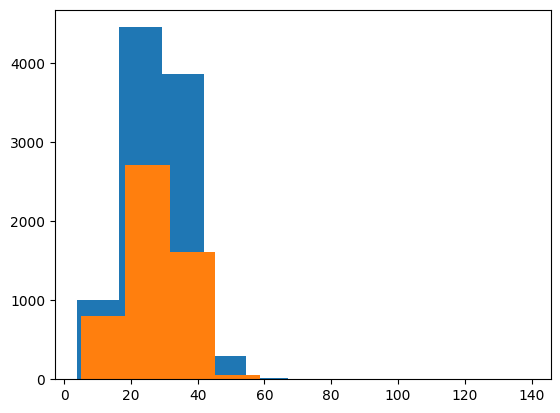

In [36]:
max_len_train, max_len_test = [],[]

for sent in train_clean['safe_text']:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  max_len_train.append(len(input_ids))

for sent in test_clean['safe_text']:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  max_len_test.append(len(input_ids))

plt.hist(max_len_train)
plt.hist(max_len_test)
print('Max sentence length in training set: {}'.format(max(max_len_train)))
print('Max sentence length in training set: {}'.format(max(max_len_test)))

In [37]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["safe_text"], 
                     max_length=72,        # <-- vary max_length to test performances
                     truncation=True, 
                     padding="max_length")

In [38]:
# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_valid = hg_valid_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/8418 [00:00<?, ? examples/s]

Map:   0%|          | 0/1203 [00:00<?, ? examples/s]

Map:   0%|          | 0/5177 [00:00<?, ? examples/s]

In [39]:
# Take a look at the data
print(dataset_train)
print(dataset_valid)
print(dataset_test)

Dataset({
    features: ['safe_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 8418
})
Dataset({
    features: ['safe_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1203
})
Dataset({
    features: ['safe_text', 'input_ids', 'attention_mask'],
    num_rows: 5177
})


* `'input_ids'` are the IDs for the tokens. 
* `'attention_mask'` indicates which token ID should get attention from the model, so the padding tokens are all zeros and other tokens are 1s. 



## 2. Transfer Learning Using Hugging Face Tranformers with Fine-Tuning

### Step 3: Load Pretrained Model

* `AutoModelForSequenceClassification` loads the RoBERTa model without the sequence classification head.
* The method `from_pretrained()` loads the weights from the pretrained model into the new model, so the weights in the new model are not randomly initialized. Note that the new weights for the new sequence classification head are going to be randomly initialized.
* `num_labels` indicates the number of classes. Set num_labels = 1 to define model as 'regression'.

In [ ]:
import gc, torch
if 'model' in globals():
    del model
torch.cuda.empty_cache()
gc.collect()

113

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_SPEC, num_labels=1) 

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

### Step 4: Set Training Argument
Hugging Face has 96 parameters for `TrainingArguments`, which provides a lot of flexibility in fine-tuning the transfer learning model. 

*Reference*:
- [TrainingArguments Document](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments)
- [How to set up Trainer for regression](https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994)

In [ ]:
# set seed to make sure results are reproducible
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
OUTPUT_DIR= '/content/transformer-'+MODEL_SPEC+'-'+TIMESTAMP
OUTPUT_DIR

'/content/transformer-roberta-large-20230415-230536'

In [ ]:
!rm -R $OUTPUT_DIR
!mkdir $OUTPUT_DIR

rm: cannot remove '/content/transformer-roberta-large-20230415-230536': No such file or directory


In [ ]:
#-----------
# define some hyperparameters
#-----------
batch_size=16
gradient_accumulation_steps = 1   # number of updates steps to accumulate the gradients for, before performing a backward/update pass.
epochs = 3
learning_rate = 5e-6

#-----------
# Calculation
#-----------
# calculate saving and evaluation steps
steps_per_epoch = int(np.ceil(len(df_train) / float(batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch))
print('Each epoch will have {:,} gradient update steps (considering gradients accumulation).'.format(steps_per_epoch//gradient_accumulation_steps))

# refine evaluate_during_training_steps
num_evaluation_per_epoch = 10      # how many evaluations I want to do in 1 epoch
evaluate_during_training_steps = int((steps_per_epoch//gradient_accumulation_steps)//num_evaluation_per_epoch)
print('Evaluation will be done by every global {:,} steps.'.format(evaluate_during_training_steps))

# calculate total training steps - total steps = [number of batches] * [number of epochs]
total_steps = len(df_train) * epochs
print('total training steps: {}'.format(total_steps))

Each epoch will have 512 steps.
Each epoch will have 512 gradient update steps (considering gradients accumulation).
Evaluation will be done by every global 51 steps.
total training steps: 24531


In [ ]:
# # learning rate scheduler
# from transformers import (get_constant_schedule, get_constant_schedule_with_warmup,
#                           get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup, 
#                           get_linear_schedule_with_warmup)
# from transformers import AdamW

# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate,
#                   eps = 1e-8  # defualt is 1e-8
#                   )

# lr_scheduler=get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=512, num_training_steps=total_steps)

In [ ]:
# # Set up training arguments in dynamic way
# training_args = TrainingArguments(
#     output_dir=OUTPUT_DIR,
#     logging_dir=OUTPUT_DIR+'/logs',
#     # logging_strategy='steps',   # "epoch"
#     # logging_steps=50,           # number of update steps between two logs if logging_strategy='steps'
#     save_total_limit=2,            # the max number of checkpoints saved. If exceeds limit, older checkpoints will be removed
#     load_best_model_at_end=True,    # the best model will be loaded at the end of the training. When it is set to `True`, the `save_strategy` and `evaluation_strategy` must be the same. When both arguments are `'steps'`, the value of `save_steps` needs to be a round multiple of the value of `eval_steps`.
#     per_device_train_batch_size=batch_size,  #<-- tune
#     per_device_eval_batch_size=batch_size,   #<-- tune
#     num_train_epochs=epochs,     #<-- tune
#     learning_rate=learning_rate, #<-- tune The initial learning rate for AdamW optimizer.
#     weight_decay=0.01,           #<-- tune
#     evaluation_strategy="steps",    # "steps":Evaluation is done (and logged) every eval_steps, "epochs":evaluation is done at the end of each epoch;"no": no evaluation 
#     eval_steps=evaluate_during_training_steps,     # if evaluation_strategy = 'step', evaluation and save happens every n steps
#     save_steps=evaluate_during_training_steps,     # number of updates steps before two checkpoint saves if save_strategy="steps". same as eval_steps
#     seed=seed,
#     lr_scheduler_type='linear',      # <-- testing: ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup', 'inverse_sqrt'], 'linear' default for simple transformers
#     warmup_steps = 300,              # <-- testing   
#     #warmup_ratio=0.06,              # <-- testing. default value of simple transformers 
# )

In [ ]:
# Set up training arguments in fixed way
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=OUTPUT_DIR+'/logs',
    # logging_strategy='steps',   # "epoch"
    # logging_steps=50,           # number of update steps between two logs if logging_strategy='steps'
    per_device_train_batch_size=16,  #<-- tune
    per_device_eval_batch_size=16,   #<-- tune
    num_train_epochs=6,      #<-- tune
    learning_rate=5e-6,      #<-- tune
    weight_decay=0.03,       #<-- tune
    gradient_accumulation_steps=1,  #<-- tune [2,3,4]
    load_best_model_at_end=True,    # the best model will be loaded at the end of the training. When it is set to `True`, the `save_strategy` and `evaluation_strategy` must be the same. When both arguments are `'steps'`, the value of `save_steps` needs to be a round multiple of the value of `eval_steps`.
    evaluation_strategy="steps",    # "steps":Evaluation is done (and logged) every eval_steps, "epochs":evaluation is done at the end of each epoch;"no": no evaluation 
    eval_steps=51,                  # if evaluation_strategy = 'step', evaluation and save happens every n steps
    save_steps=51,                  # number of updates steps before two checkpoint saves if save_strategy="steps". same as eval_steps
    save_total_limit=3,            # the max number of checkpoints saved. If exceeds limit, older checkpoints will be removed
    seed=seed,
    lr_scheduler_type='linear',     # <-- testing: 'linear', 'cosine','COSINE_WITH_RESTARTS','POLYNOMIAL','CONSTANT','CONSTANT_WITH_WARMUP','INVERSE_SQRT'. default value of simple transformers 
    warmup_steps = 307,             # <-- testing   
    #warmup_ratio=0.06,             # <-- testing. default value of simple transformers 
)

### Step 5: Set Evaluation Metrics

We will set the evaluation metric because Hugging Face Trainer does not evaluate the model performance automatically during the training process.

*Reference*:
- [Evaluate libray from Hugging Face](https://huggingface.co/docs/evaluate/transformers_integrations)

In [ ]:
# compute the metric
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  metric = evaluate.load('mse')
  return metric.compute(predictions=predictions, references=labels, squared=False)

### Step 6: Train Model Using Transformer Trainer

In step 9, we will train the model using the transformer `Trainer`.
* model is the model for training, evaluation, or prediction by the `Trainer`.
* `args` takes the arguments for tweaking the `Trainer`. It defaults to the instance of `TrainingArguments`.
* `train_dataset` is the training dataset name. If the dataset is in `Dataset` format, the unused columns will be automatically ignored. In our training dataset, `__index_level_0__` and `review` are not used by the model, so they are ignored.
* `eval_dataset` is the evaluation dataset name. Similar to the `train_dataset`, the unused columns will be automatically ignored for the `Dataset` format.
* `compute_metrics` takes the function for calculating evaluation metrics.
* `callbacks` takes a list of callbacks to customize the training loop. `EarlyStoppingCallback` stops the training by `early_stopping_patience` for the evaluation calls. There is no practical need to use early stopping because there are only two epochs for the model. It is included as an example code reference.

In [ ]:
# call backs
early_stopping = EarlyStoppingCallback(early_stopping_patience=20, early_stopping_threshold=0.0)

In [ ]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.train()

Step,Training Loss,Validation Loss,Mse
51,No log,0.446742,0.668388
102,No log,0.424977,0.651903
153,No log,0.419302,0.647536
204,No log,0.398584,0.631335
255,No log,0.367683,0.606369
306,No log,0.336553,0.580132
357,No log,0.309723,0.556528
408,No log,0.304897,0.552175
459,No log,0.346778,0.588878
510,0.403700,0.252446,0.502440


TrainOutput(global_step=2805, training_loss=0.2199268878249986, metrics={'train_runtime': 1401.8642, 'train_samples_per_second': 34.998, 'train_steps_per_second': 2.191, 'total_flos': 5871803013552240.0, 'train_loss': 0.2199268878249986, 'epoch': 5.48})

### Step 7: Model Performance Evaluation
`trainer.evaluate` is a quick way to get the loss and the accuracy of the validation dataset. 

In [ ]:
# Trainer evaluate
trainer.evaluate(dataset_valid)

{'eval_loss': 0.21529985964298248,
 'eval_mse': 0.4640041559596084,
 'eval_runtime': 5.62,
 'eval_samples_per_second': 256.938,
 'eval_steps_per_second': 16.192,
 'epoch': 5.48}

Make predictions

Under `PredictionOutput`, `predictions` has the logits for each class. logit is the last layer of the neural network before softmax is applied. `label_ids` has the actual labels. Please note that it is not predicted labels although it is under the `PredictionOutput`. We need to calculate the predicted labels based on the logit values.

Under `metrics` there is information about the testing predictions.
 * `test_loss` is the loss for the testing dataset.  
 * `test_accuracy` is the percentage of correct predictions.
 * `test_runtime` is the runtime for testing.
 * `test_samples_per_second` is the number of samples the model can process in one second.
 * `test_steps_per_second` is the number of steps the model can process in one second.


In [ ]:
# make predictions
y_valid_pred_dict = trainer.predict(dataset_valid)

# Take a look at the predictions
y_valid_pred_dict

PredictionOutput(predictions=array([[0.85730886],
       [0.8894786 ],
       [0.93889725],
       ...,
       [0.87680393],
       [0.20162897],
       [0.86120284]], dtype=float32), label_ids=array([1., 1., 1., ..., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.21529985964298248, 'test_mse': 0.4640041559596084, 'test_runtime': 5.8562, 'test_samples_per_second': 246.576, 'test_steps_per_second': 15.539})

In [ ]:
# extract predicted values
y_valid_pred_val = y_valid_pred_dict.predictions
y_valid_pred_val = np.clip(y_valid_pred_val, -1, 1)
rmse_0_trial = mean_squared_error(df_val['label'], y_valid_pred_val)**0.5
print(f"RMSE on validation set: {mean_squared_error(df_val['label'], y_valid_pred_val)**0.5}")

RMSE on validation set: 0.4639897399006091


Number of instances with 0.0 predictions: 5


(array([ 20.,  28.,  17.,  21.,  12.,  12.,   6.,   9.,   8.,   9.,   6.,
         13.,  10.,  16., 128., 290.,  90.,  47.,  29.,  29.,  16.,  26.,
         24.,  25.,  28.,  40.,  61.,  86., 205., 133.]),
 array([-0.93717986, -0.87260723, -0.80803454, -0.74346185, -0.67888921,
        -0.61431658, -0.54974389, -0.48517123, -0.42059857, -0.3560259 ,
        -0.29145324, -0.22688058, -0.16230792, -0.09773526, -0.03316259,
         0.03141007,  0.09598273,  0.16055539,  0.22512805,  0.28970072,
         0.35427338,  0.41884604,  0.4834187 ,  0.54799139,  0.61256403,
         0.67713666,  0.74170935,  0.80628204,  0.87085468,  0.93542731,
         1.        ]),
 <BarContainer object of 30 artists>)

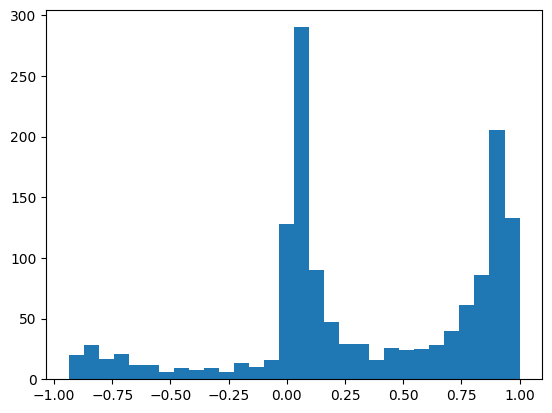

In [ ]:
# audit 1 - make sure there is no exact 0 predictions
print("Number of instances with 0.0 predictions: {}".format(len([pred for pred in y_valid_pred_val if pred == 1])))

# audit 2 - check prediction distribution
plt.hist(y_valid_pred_val, bins=30)

count    5177.000000
mean        0.330205
std         0.501885
min        -0.978731
25%         0.037588
50%         0.198918
75%         0.851510
max         1.000000
Name: score, dtype: float64


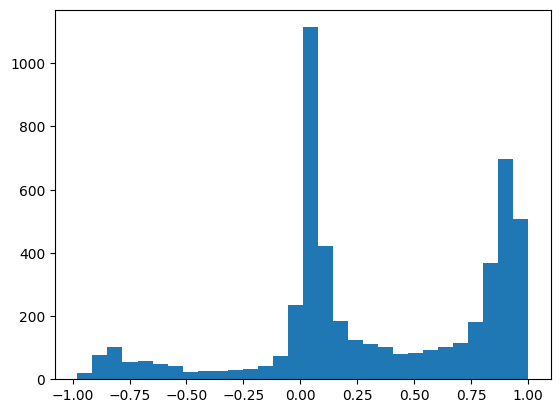

In [ ]:
# make predictions on test set
df_y_pred = make_predictions(dataset_test, trainer, df_test=test_clean)

In [ ]:
# save predictions to .csv
fname = MODEL_SPEC + '_' \
        +'batch_size' + str(16) + '_' \
        + 'lr' + str(1e-6) + '_' \
        + 'weight_decay' + str(0.03) + '_' \
        + 'lr_scheduler' + 'cosine' + '_' \
        + 'seed' + str(42) + '_' \
        + TIMESTAMP
print(fname)

# output results
df_y_pred.to_csv(fname+'.csv',index=False)

roberta-large_batch_size16_lr1e-06_weight_decay0.03_lr_schedulercosine_seed42_20230415-230536


In [ ]:
# output results
df_y_pred.to_csv('zindi_nocleaning_lr5e-6_epoc6_wdcay0.03_linear307_0.4549'+'.csv',index=False)

## 3. Adjust SequenceClassification Configuration

*Reference*:
- [transformers-pretrained-model-with-dropout-setting](https://stackoverflow.com/questions/64947064/transformers-pretrained-model-with-dropout-setting)

#### Step 1. Adjust Dropout Rates for Roberta

There are two dropout parameters and that you are using a specific RoBERTa model, that is `RobertaForSequenceClassification`.

In [ ]:
from transformers import RobertaModel, AutoConfig

In [ ]:
configuration = AutoConfig.from_pretrained(MODEL_SPEC, num_labels=1)
configuration

RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Default values of `attention_probs_dropout_prob` and `hidden_dropout_prob` are both 0.1. It seems too low and cause overfitting during transfer learning. We would like to increase the drop out rates and measure how it impact model training.

classification head:  RobertaForSequenceClassification: RoBERTa Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output) e.g. for GLUE tasks.

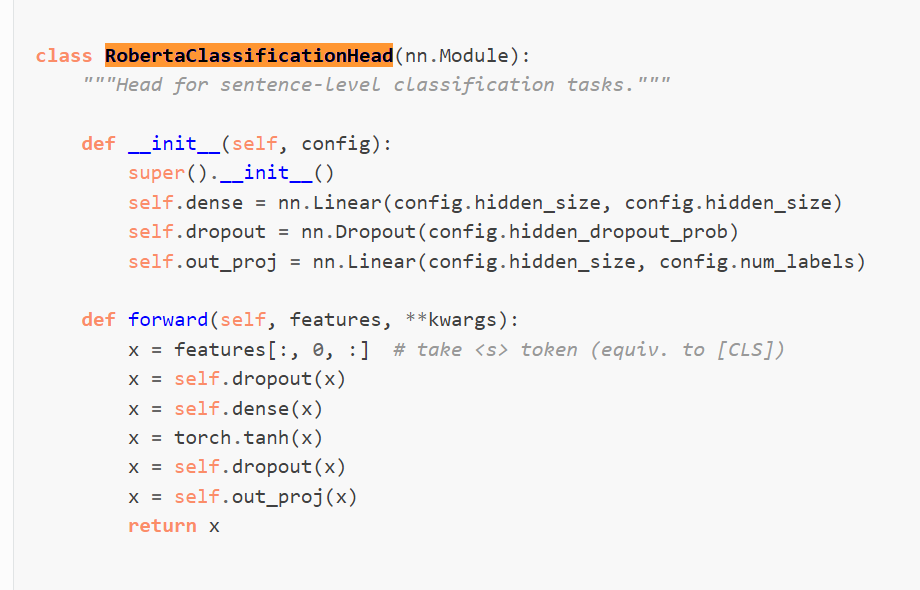

In [ ]:
# increase dropout rate in classification head
configuration.hidden_dropout_prob = 0.05            # default 0.1
configuration.attention_probs_dropout_prob = 0.1   # default 0.1, when I set attention_dropout_prob = 0.5, somehow validation loss is ~0.465 but test score is 0.495+. I probably should not tune it or set it too high
#configuration.hidden_size=1024 # default 1024 seems cannot be changed

### Step 2: Load Pretrained Model With Customized Configuration

In [ ]:
import gc, torch
if 'model' in globals():
    del model_reconfig
torch.cuda.empty_cache()
gc.collect()

84

In [ ]:
# Load model with updated configuration
model_reconfig = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=MODEL_SPEC, config=configuration) 

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

### Step 3: Set Training Argument
Hugging Face has 96 parameters for `TrainingArguments`, which provides a lot of flexibility in fine-tuning the transfer learning model. 

*Reference*:
- [TrainingArguments Document](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments)
- [How to set up Trainer for regression](https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994)

In [ ]:
# set seed to make sure results are reproducible
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
OUTPUT_DIR= '/content/transformer-'+MODEL_SPEC+'-custom-'+'-'+TIMESTAMP
OUTPUT_DIR

'/content/transformer-roberta-large-custom--20230416-053722'

In [ ]:
!rm -R $OUTPUT_DIR
!mkdir $OUTPUT_DIR

rm: cannot remove '/content/transformer-roberta-large-custom--20230416-053722': No such file or directory


In [ ]:
#-----------
# define some hyperparameters
#-----------
batch_size=16
gradient_accumulation_steps = 1   # number of updates steps to accumulate the gradients for, before performing a backward/update pass.
epochs = 3
learning_rate = 5e-6

#-----------
# Calculation
#-----------
# calculate saving and evaluation steps
steps_per_epoch = int(np.ceil(len(df_train) / float(batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch))
print('Each epoch will have {:,} gradient update steps (considering gradients accumulation).'.format(steps_per_epoch//gradient_accumulation_steps))

# refine evaluate_during_training_steps - I would like to do early stopping evalution 4 times in each epoch
num_evaluation_per_epoch = 10      # how many evaluations I want to do in 1 epoch
evaluate_during_training_steps = int((steps_per_epoch//gradient_accumulation_steps)//num_evaluation_per_epoch)
print('Evaluation will be done by every global {:,} steps.'.format(evaluate_during_training_steps))

# calculate total training steps - total steps = [number of batches] * [number of epochs]
total_steps = len(df_train) * epochs
print('total training steps: {}'.format(total_steps))

Each epoch will have 512 steps.
Each epoch will have 512 gradient update steps (considering gradients accumulation).
Evaluation will be done by every global 51 steps.
total training steps: 24531


In [ ]:
# Set up training arguments in fixed way
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=OUTPUT_DIR+'/logs',
    # logging_strategy='steps',   # "epoch"
    # logging_steps=50,           # number of update steps between two logs if logging_strategy='steps'
    per_device_train_batch_size=16,  #<-- tune, 16 is good choice
    per_device_eval_batch_size=16,   #<-- tune, 16 is good choice
    num_train_epochs=30,     #<-- tune, keep it slightly higher and apply early stopping
    learning_rate=5e-6,      #<-- tune, recommend to explore 1e-6 to 1e-4 [5e-6 a bit low]
    weight_decay=0.03,       #<-- tune, 0.03 is good choice
    gradient_accumulation_steps=1,  #<-- tune [2,3,4]
    load_best_model_at_end=True,    # the best model will be loaded at the end of the training. When it is set to `True`, the `save_strategy` and `evaluation_strategy` must be the same. When both arguments are `'steps'`, the value of `save_steps` needs to be a round multiple of the value of `eval_steps`.
    evaluation_strategy="steps",    # "steps":Evaluation is done (and logged) every eval_steps, "epochs":evaluation is done at the end of each epoch;"no": no evaluation 
    eval_steps=evaluate_during_training_steps,                  # if evaluation_strategy = 'step', evaluation and save happens every n steps
    save_steps=evaluate_during_training_steps,                  # number of updates steps before two checkpoint saves if save_strategy="steps". same as eval_steps
    save_total_limit=3,            # the max number of checkpoints saved. If exceeds limit, older checkpoints will be removed
    seed=seed,
    lr_scheduler_type='linear',     # <-- testing: 'linear', 'cosine','COSINE_WITH_RESTARTS','POLYNOMIAL','CONSTANT','CONSTANT_WITH_WARMUP','INVERSE_SQRT'. default value of simple transformers 
    warmup_steps = 307,             # <-- testing   
    #warmup_ratio=0.06,             # <-- testing. default value of simple transformers 
)

### Step 5: Set Evaluation Metrics

We will set the evaluation metric because Hugging Face Trainer does not evaluate the model performance automatically during the training process.

*Reference*:
- [Evaluate libray from Hugging Face](https://huggingface.co/docs/evaluate/transformers_integrations)

In [ ]:
# compute the metric
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  metric = evaluate.load('mse')
  return metric.compute(predictions=predictions, references=labels, squared=False)

### Step 6: Train Model Using Transformer Trainer

In step 9, we will train the model using the transformer `Trainer`.
* model is the model for training, evaluation, or prediction by the `Trainer`.
* `args` takes the arguments for tweaking the `Trainer`. It defaults to the instance of `TrainingArguments`.
* `train_dataset` is the training dataset name. If the dataset is in `Dataset` format, the unused columns will be automatically ignored. In our training dataset, `__index_level_0__` and `review` are not used by the model, so they are ignored.
* `eval_dataset` is the evaluation dataset name. Similar to the `train_dataset`, the unused columns will be automatically ignored for the `Dataset` format.
* `compute_metrics` takes the function for calculating evaluation metrics.
* `callbacks` takes a list of callbacks to customize the training loop. `EarlyStoppingCallback` stops the training by `early_stopping_patience` for the evaluation calls. There is no practical need to use early stopping because there are only two epochs for the model. It is included as an example code reference.

In [ ]:
# call backs
early_stopping = EarlyStoppingCallback(early_stopping_patience=num_evaluation_per_epoch*5, early_stopping_threshold=0.0)

In [ ]:
# Train the model
trainer = Trainer(
    model=model_reconfig,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.train()

Step,Training Loss,Validation Loss,Mse
51,No log,0.463269,0.680639
102,No log,0.431951,0.657230
153,No log,0.417802,0.646376
204,No log,0.403442,0.635171
255,No log,0.447047,0.668616
306,No log,0.348193,0.590078
357,No log,0.382005,0.618065
408,No log,0.311461,0.558087
459,No log,0.431909,0.657198
510,0.402600,0.313854,0.560226


TrainOutput(global_step=3876, training_loss=0.16511391510781365, metrics={'train_runtime': 1981.1893, 'train_samples_per_second': 123.82, 'train_steps_per_second': 7.753, 'total_flos': 8113585456356048.0, 'train_loss': 0.16511391510781365, 'epoch': 7.57})

### Step 7: Model Performance Evaluation
`trainer.evaluate` is a quick way to get the loss and the accuracy of the validation dataset. 

In [ ]:
# Trainer evaluate
trainer.evaluate(dataset_valid)

{'eval_loss': 0.22269102931022644,
 'eval_mse': 0.47190150673217507,
 'eval_runtime': 6.2856,
 'eval_samples_per_second': 229.73,
 'eval_steps_per_second': 14.477,
 'epoch': 7.57}

Make predictions

Under `PredictionOutput`, `predictions` has the logits for each class. logit is the last layer of the neural network before softmax is applied. `label_ids` has the actual labels. Please note that it is not predicted labels although it is under the `PredictionOutput`. We need to calculate the predicted labels based on the logit values.

Under `metrics` there is information about the testing predictions.
 * `test_loss` is the loss for the testing dataset.  
 * `test_accuracy` is the percentage of correct predictions.
 * `test_runtime` is the runtime for testing.
 * `test_samples_per_second` is the number of samples the model can process in one second.
 * `test_steps_per_second` is the number of steps the model can process in one second.


In [ ]:
# make predictions
y_valid_pred_dict = trainer.predict(dataset_valid)

# Take a look at the predictions
y_valid_pred_dict

PredictionOutput(predictions=array([[ 0.8268503 ],
       [ 0.95213145],
       [ 0.87024045],
       ...,
       [ 0.49487144],
       [-0.67852044],
       [ 0.9166614 ]], dtype=float32), label_ids=array([1., 1., 1., ..., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.22269102931022644, 'test_mse': 0.47190150673217507, 'test_runtime': 6.4441, 'test_samples_per_second': 224.08, 'test_steps_per_second': 14.121})

In [ ]:
# extract predicted values
y_valid_pred_val = y_valid_pred_dict.predictions
y_valid_pred_val = np.clip(y_valid_pred_val, -1, 1)
rmse_0_trial = mean_squared_error(df_val['label'], y_valid_pred_val)**0.5
print(f"RMSE on validation set: {mean_squared_error(df_val['label'], y_valid_pred_val)**0.5}")

RMSE on validation set: 0.47137803511941057


Number of instances with 0.0 predictions: 16


(array([ 51.,  12.,   8.,   8.,  14.,   5.,  10.,   6.,   6.,   8.,  10.,
          8.,  17.,  29., 141., 292.,  79.,  54.,  48.,  30.,  32.,  33.,
         21.,  27.,  29.,  27.,  37.,  77., 162., 163.]),
 array([-1.        , -0.93333334, -0.86666667, -0.80000001, -0.73333335,
        -0.66666669, -0.60000002, -0.53333336, -0.46666667, -0.40000001,
        -0.33333334, -0.26666668, -0.2       , -0.13333334, -0.06666667,
         0.        ,  0.06666667,  0.13333334,  0.2       ,  0.26666668,
         0.33333334,  0.40000001,  0.46666667,  0.53333336,  0.60000002,
         0.66666669,  0.73333335,  0.80000001,  0.86666667,  0.93333334,
         1.        ]),
 <BarContainer object of 30 artists>)

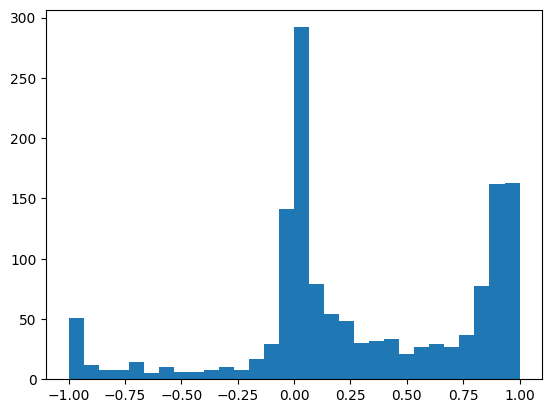

In [ ]:
# audit 1 - make sure there is no exact 0 predictions
print("Number of instances with 0.0 predictions: {}".format(len([pred for pred in y_valid_pred_val if pred == 1])))

# audit 2 - check prediction distribution
plt.hist(y_valid_pred_val, bins=30)

count    5177.000000
mean        0.294170
std         0.513060
min        -1.000000
25%         0.001898
50%         0.140584
75%         0.833343
max         1.000000
Name: score, dtype: float64


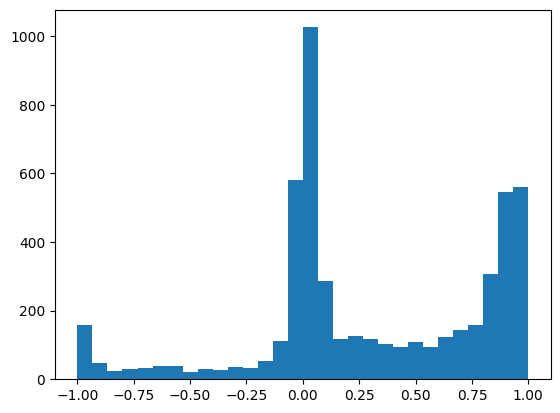

In [ ]:
# make predictions on test set
df_y_pred = make_predictions(dataset_test, trainer, df_test=test_clean)

In [ ]:
# save predictions to .csv
fname = MODEL_SPEC + '_' \
        +'batch_size' + str(16) + '_' \
        + 'lr' + str(5e-6) + '_' \
        + 'weight_decay' + str(0.03) + '_' \
        + 'lr_scheduler' + 'linear' + '_' \
        + 'seed' + str(128) + '_' \
        + 'hidden_dp' + str(0.05) + '_' \
        + TIMESTAMP
print(fname)

# output results
df_y_pred.to_csv(fname+'.csv',index=False)

roberta-large_batch_size16_lr5e-06_weight_decay0.03_lr_schedulerlinear_seed128_hidden_dp0.05_20230416-053722


In [ ]:
df_y_pred.to_csv('rb_hiddendp_0.2_0.465.csv',index=False)

## 4. [Skip]Hyperparameter Tuning Using Trainer API

*Reference*:
- [Hyperparameter Tuning Using Trainer API](https://huggingface.co/docs/transformers/hpo_train)
- [Optuna Pythonic Search Space](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py)

In [ ]:
# !rm -R /content/transformer-roberta-large-20230415-203929
# !rm -R /content/transformer-roberta-large-20230415-210050

In [ ]:
# import gc, torch
# if 'best_run' in globals():
#   del best_run
# torch.cuda.empty_cache()
# gc.collect()

During hyperparameter search, the Trainer will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. 

In [ ]:
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(MODEL_SPEC, num_labels=1)

Define hyperparameter search space

In [ ]:
# def optuna_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 3e-6, 3e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_int("per_device_train_batch_size", 8, 32, 2),
#         "weight_decay": trial.suggest_categorical("weight_decay",[0.0, 0.01, 0.02, 0.03]),
#     }

In [ ]:
# # training arguments
# training_args = TrainingArguments(
#     output_dir=OUTPUT_DIR,
#     logging_dir=OUTPUT_DIR+'/logs',
#     # logging_strategy='steps',   # "epoch"
#     # logging_steps=50,           # number of update steps between two logs if logging_strategy='steps'
#     # per_device_train_batch_size=16,  #<-- tune
#     # per_device_eval_batch_size=16,   #<-- tune
#     num_train_epochs=6,      #<-- tune
#     # learning_rate=5e-6,      #<-- tune
#     weight_decay=0.03,       #<-- tune
#     load_best_model_at_end=True,    # the best model will be loaded at the end of the training. When it is set to `True`, the `save_strategy` and `evaluation_strategy` must be the same. When both arguments are `'steps'`, the value of `save_steps` needs to be a round multiple of the value of `eval_steps`.
#     evaluation_strategy="steps",    # "steps":Evaluation is done (and logged) every eval_steps, "epochs":evaluation is done at the end of each epoch;"no": no evaluation 
#     eval_steps=51,                  # if evaluation_strategy = 'step', evaluation and save happens every n steps
#     save_steps=51,                  # number of updates steps before two checkpoint saves if save_strategy="steps". same as eval_steps
#     save_total_limit=3,            # the max number of checkpoints saved. If exceeds limit, older checkpoints will be removed
#     seed=seed,
#     lr_scheduler_type='linear',     # <-- testing: 'linear', 'cosine','COSINE_WITH_RESTARTS','POLYNOMIAL','CONSTANT','CONSTANT_WITH_WARMUP','INVERSE_SQRT'. default value of simple transformers 
#     warmup_steps = 307,             # <-- testing   
#     #warmup_ratio=0.06,             # <-- testing. default value of simple transformers 
# )

# # call backs
# early_stopping = EarlyStoppingCallback(early_stopping_patience=20, early_stopping_threshold=0.0)

The method we call this time is hyperparameter_search. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the train_dataset line above by:

`train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10)`
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
# sample = False

# if sample == True:
#   small_train_dataset = dataset_train.shard(index=1, num_shards=5)
# else:
#   small_train_dataset = dataset_train

In [ ]:
# # instantiate our Trainer
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=dataset_valid,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[early_stopping]
# )

You can customize the objective to maximize by passing along a `compute_objective` function to the hyperparameter_search method, and you can customize the search space by passing a `hp_space` argument to hyperparameter_search. See this forum post for some examples.

In [ ]:
# best_run = trainer.hyperparameter_search(n_trials=15, 
#                                          backend="optuna",
#                                          hp_space=optuna_hp_space,
#                                          direction="minimize")

The hyperparameter_search method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
# best_run

To reproduce the best training, just set the hyperparameters in your TrainingArgument before creating a Trainer:

In [ ]:
# for n, v in best_run.hyperparameters.items():
#     setattr(trainer.args, n, v)

In [ ]:
# # reinitiate Trainer with full dataset
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=dataset_train,
#     eval_dataset=dataset_valid,
#     compute_metrics=compute_metrics,
#     callbacks=[early_stopping]
# )

In [ ]:
# trainer.train()

In [ ]:
# # Trainer evaluate
# trainer.evaluate(dataset_valid)

In [ ]:
# # make predictions
# y_valid_pred_dict = trainer.predict(dataset_valid)

# # Take a look at the predictions
# y_valid_pred_dict

In [ ]:
# # extract predicted values
# y_valid_pred_val = y_valid_pred_dict.predictions
# y_valid_pred_val = np.clip(y_valid_pred_val, -1, 1)
# print(f"RMSE on validation set: {mean_squared_error(df_val['label'], y_valid_pred_val)**0.5}")

In [ ]:
# # audit 1 - make sure there is no exact 0 predictions
# print("Number of instances with 0.0 predictions: {}".format(len([pred for pred in y_valid_pred_val if pred == 1])))

# # audit 2 - check prediction distribution
# plt.hist(y_valid_pred_val, bins=30)

In [ ]:
# # make predictions on test set
# df_y_pred = make_predictions(dataset_test, trainer, df_test=test_clean)

In [ ]:
# df_y_pred.to_csv('/content/drive/MyDrive/nlp/zindi/outputs/'\
#                  +'hp_lr3e-6_3e-5_bsize8-32_wdec_0_0.03'\
#                  +'.csv', index=False)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## 5. Hyperparameter Tuning With Optuna

*Reference*:
- [Hyperparameter Tuning Using Trainer API](https://huggingface.co/docs/transformers/hpo_train)
- [Optuna Pythonic Search Space](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py)
- [Transformer Model Hyperparameter Optimization With Optuna](https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8)

In [ ]:
#!rm -R /content/hp_20230416-214815
#!rm -R /content/transformer-roberta-large-20230415-210050

In [48]:
import gc, torch
if 'study' in globals():
  del study
torch.cuda.empty_cache()
gc.collect()

0

### a. Define Optuna Objective Function

*Reference*:
- [optuna.trial document](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)

In [49]:
def objective(trial: optuna.Trial, seed=seed, model_name=MODEL_SPEC, subsample_train=False): 

  # 1) define hyperparameter search space
  #num_train_epochs=trial.suggest_int("num_train_epochs", low=2, high=5),
  #weight_decay = trial.suggest_float("weight_decay", low=3e-3, high=3e-2)
  #batch_size = trial.suggest_int("training_batch_size", low=8, high=24,step=2)   
  num_train_epochs=20
  weight_decay=0.03 
  gradient_accumulation_steps=1
  batch_size=16
  num_evaluation_per_epoch=4       # for early stopping, how many evaluations I want to do in 1 epoch
  learing_rate = trial.suggest_float("learning_rate", low=4e-6, high=1e-5, log=True)  #log=True, lower values tend to be more sampled than higher values
  hidden_dropout_prob = trial.suggest_float("hidden_dropout_prob", low=0.05, high=0.22)  # default 0.1
  #attention_probs_dropout_prob = trial.suggest_float("attention_probs_dropout_prob", low=0.1, high=0.7) # default 0.1

  # 2) initialize model - classification head
  from transformers import RobertaModel, AutoConfig
  configuration = AutoConfig.from_pretrained(model_name, num_labels=1)

  configuration.hidden_dropout_prob = hidden_dropout_prob 
  #configuration.attention_probs_dropout_prob = attention_probs_dropout_prob        

  model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=configuration)

  # 3) define training arguments
  steps_per_epoch = int(np.ceil(len(df_train) / float(batch_size)))
  evaluate_during_training_steps = int((steps_per_epoch//gradient_accumulation_steps)//num_evaluation_per_epoch)

  training_args = TrainingArguments(
      output_dir="hp_"+TIMESTAMP,
      logging_dir = "hp_"+TIMESTAMP + '/logs',
      num_train_epochs = num_train_epochs, 
      per_device_train_batch_size = batch_size,
      per_device_eval_batch_size = batch_size,
      learning_rate = learing_rate,
      weight_decay=weight_decay,
      load_best_model_at_end=True,
      evaluation_strategy="steps",
      eval_steps=evaluate_during_training_steps, 
      save_steps=evaluate_during_training_steps,
      save_total_limit=1,
      seed=seed,
      lr_scheduler_type='linear',     # <-- testing: 'linear', 'cosine','COSINE_WITH_RESTARTS','POLYNOMIAL','CONSTANT','CONSTANT_WITH_WARMUP','INVERSE_SQRT'. default value of simple transformers 
      warmup_steps = 307,             # <-- testing   
      #warmup_ratio=0.06,             # <-- testing. default value of simple transformers 
  )

  # 4) define callbacks
  early_stopping = EarlyStoppingCallback(early_stopping_patience=num_evaluation_per_epoch*4, early_stopping_threshold=0.0)

  # 5) whether subsample trainingi data
  if subsample_train == True:
    small_train_dataset = dataset_train.shard(index=1, num_shards=3)
  else:
    small_train_dataset = dataset_train

  # 6) define trainer
  # compute the metric
  def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load('mse')
    return metric.compute(predictions=predictions, references=labels, squared=False)

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
  )
  
  # 7) train the model
  print('hyperparameters are: learning_rate {},  \n hidden_dropout_prob {}, \n batch_size {}'.format(learing_rate, hidden_dropout_prob, batch_size))
  trainer.train()

  # 8) calculate validation rmse
  print('evaluating model performance on validation set')
  y_valid_pred_dict = trainer.predict(dataset_valid)
  y_valid_pred_val = y_valid_pred_dict.predictions
  y_valid_pred_val = np.clip(y_valid_pred_val, -1, 1)
  rmse_val = mean_squared_error(df_val['label'], y_valid_pred_val)**0.5
  print('validation loss {}'.format(rmse_val))

  df_val_with_id = pd.merge(df_val, train_clean, left_index=True, right_index=True)
  df_y_pred_valid = pd.DataFrame({'tweet_id':df_val_with_id.tweet_id, 
                                  'label_pred':y_valid_pred_val.ravel(), 
                                  'label_actual':df_val['label']})

  # 9) make predictions on test set
  print('making predictions on test set')
  df_y_pred = make_predictions(dataset_test, trainer, df_test=test_clean)
  gdrive_folder = '/content/drive/MyDrive/nlp/zindi/outputs/optuna_4/'
  fname = 'lr'+str(learing_rate)+'_'+'hidden_dropout'+str(hidden_dropout_prob)+'_'+'val_rmse'+str(rmse_val)

  # 10) save both training and validation predictions to google drive
  df_y_pred.to_csv(gdrive_folder+'/test/'+fname+'.csv',index=False)  #test
  df_y_pred_valid.to_csv(gdrive_folder+'/valid/'+fname+'.csv',index=False)  #valid
  print('validation and test predictions are saved on google drive')
  
  return rmse_val

In [50]:
# We want to minimize the validation loss
study = optuna.create_study(study_name="hyper-parameter-search"+TIMESTAMP, 
                            direction="minimize")

[I 2023-04-17 07:02:19,829] A new study created in memory with name: hyper-parameter-search20230417-065727


Note from a reader: By default, during the first 10 trials, the random sampler is used via TPEsampler, so we might see more improvement when we increase n_trials > 10.

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.4954056228970945e-06,  
 hidden_dropout_prob 0.11221475375273246, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.417445,0.646100
262,No log,0.377540,0.614443
393,No log,0.309613,0.556429
524,0.404300,0.340308,0.583359
655,0.404300,0.242125,0.492062
786,0.404300,0.239779,0.489673
917,0.404300,0.237499,0.487338
1048,0.275000,0.263218,0.513048
1179,0.275000,0.272207,0.521734
1310,0.275000,0.240949,0.490866


evaluating model performance on validation set


validation loss 0.4647692729685942
making predictions on test set


count    5177.000000
mean        0.296632
std         0.500983
min        -1.000000
25%        -0.004078
50%         0.114210
75%         0.855566
max         1.000000
Name: score, dtype: float64


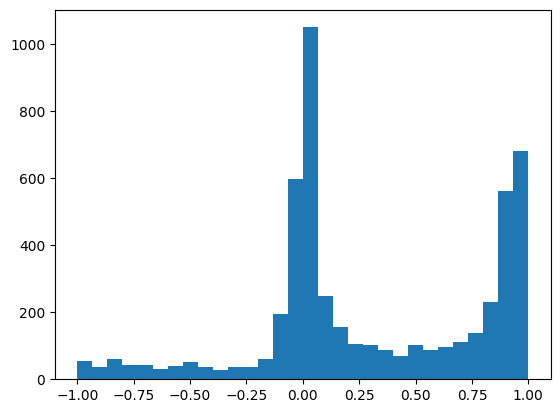

[I 2023-04-17 07:22:48,836] Trial 0 finished with value: 0.4647692729685942 and parameters: {'learning_rate': 5.4954056228970945e-06, 'hidden_dropout_prob': 0.11221475375273246}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.130007796738948e-06,  
 hidden_dropout_prob 0.10553440020779095, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.419792,0.647914
262,No log,0.385589,0.620958
393,No log,0.343254,0.585879
524,0.412300,0.336930,0.580456
655,0.412300,0.246638,0.496626
786,0.412300,0.237604,0.487447
917,0.412300,0.243370,0.493326
1048,0.288800,0.238031,0.487884
1179,0.288800,0.232832,0.482527
1310,0.288800,0.247639,0.497633


evaluating model performance on validation set


validation loss 0.4804261096231083
making predictions on test set


count    5177.000000
mean        0.307795
std         0.484765
min        -1.000000
25%        -0.011050
50%         0.165279
75%         0.803073
max         1.000000
Name: score, dtype: float64


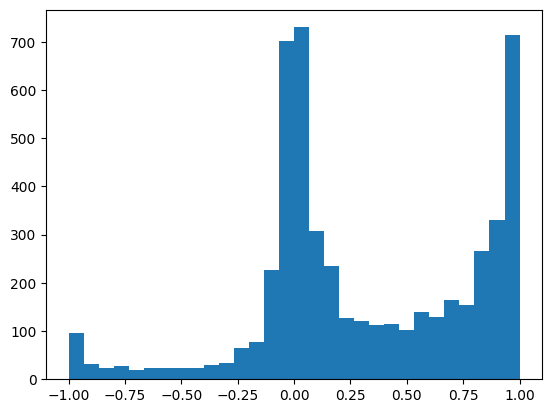

validation and test predictions are saved on google drive


[I 2023-04-17 07:41:23,352] Trial 1 finished with value: 0.4804261096231083 and parameters: {'learning_rate': 5.130007796738948e-06, 'hidden_dropout_prob': 0.10553440020779095}. Best is trial 0 with value: 0.4647692729685942.
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

hyperparameters are: learning_rate 8.41084485518996e-06,  
 hidden_dropout_prob 0.16035409288979663, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.441004,0.664081
262,No log,0.364585,0.603809
393,No log,0.362941,0.602446
524,0.482900,0.299284,0.547069
655,0.482900,0.242470,0.492413
786,0.482900,0.249839,0.499839
917,0.482900,0.264890,0.514674
1048,0.311100,0.248404,0.498401
1179,0.311100,0.242986,0.492937
1310,0.311100,0.247073,0.497064


evaluating model performance on validation set


validation loss 0.4731922598130145
making predictions on test set


count    5177.000000
mean        0.390951
std         0.489927
min        -0.818718
25%         0.060874
50%         0.234445
75%         0.938070
max         1.000000
Name: score, dtype: float64


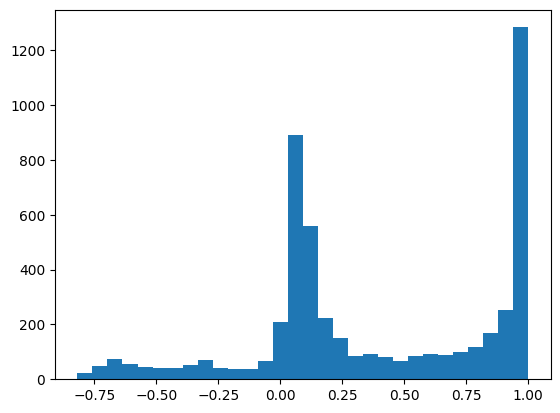

validation and test predictions are saved on google drive


[I 2023-04-17 07:59:58,860] Trial 2 finished with value: 0.4731922598130145 and parameters: {'learning_rate': 8.41084485518996e-06, 'hidden_dropout_prob': 0.16035409288979663}. Best is trial 0 with value: 0.4647692729685942.
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

hyperparameters are: learning_rate 6.9114173186697624e-06,  
 hidden_dropout_prob 0.11326915598053185, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.423779,0.650983
262,No log,0.368411,0.606969
393,No log,0.344975,0.587345
524,0.472700,0.315083,0.561323
655,0.472700,0.253315,0.503304
786,0.472700,0.248162,0.498159
917,0.472700,0.234575,0.484329
1048,0.298500,0.248008,0.498004
1179,0.298500,0.246299,0.496285
1310,0.298500,0.250100,0.500100


evaluating model performance on validation set


validation loss 0.48425618383057484
making predictions on test set


count    5177.000000
mean        0.306597
std         0.401240
min        -1.000000
25%         0.010697
50%         0.172864
75%         0.676161
max         1.000000
Name: score, dtype: float64


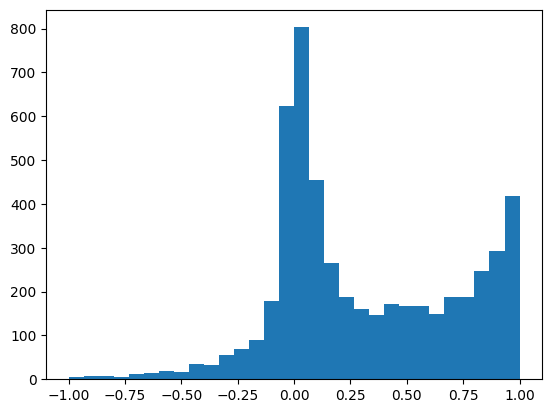

[I 2023-04-17 08:15:58,591] Trial 3 finished with value: 0.48425618383057484 and parameters: {'learning_rate': 6.9114173186697624e-06, 'hidden_dropout_prob': 0.11326915598053185}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.0071251081630275e-06,  
 hidden_dropout_prob 0.20719512205578644, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.428016,0.654229
262,No log,0.415677,0.644730
393,No log,0.396550,0.629722
524,0.458700,0.402210,0.634200
655,0.458700,0.320579,0.566197
786,0.458700,0.333104,0.577152
917,0.458700,0.284428,0.533318
1048,0.371300,0.259784,0.509690
1179,0.371300,0.258264,0.508197
1310,0.371300,0.226235,0.475641


evaluating model performance on validation set


validation loss 0.47477102443962854
making predictions on test set


count    5177.000000
mean        0.374103
std         0.466479
min        -1.000000
25%         0.024038
50%         0.307392
75%         0.849543
max         1.000000
Name: score, dtype: float64


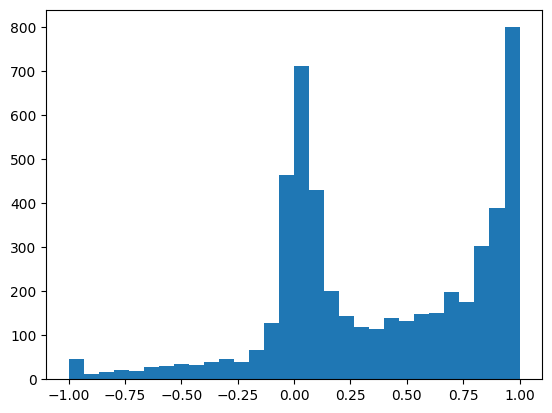

[I 2023-04-17 08:34:03,067] Trial 4 finished with value: 0.47477102443962854 and parameters: {'learning_rate': 5.0071251081630275e-06, 'hidden_dropout_prob': 0.20719512205578644}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 6.477414550870838e-06,  
 hidden_dropout_prob 0.06345795818140704, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.414463,0.643788
262,No log,0.393666,0.627428
393,No log,0.316075,0.562206
524,0.391700,0.276782,0.526101
655,0.391700,0.338624,0.581914
786,0.391700,0.236302,0.486109
917,0.391700,0.247393,0.497386
1048,0.260900,0.259376,0.509290
1179,0.260900,0.286520,0.535276
1310,0.260900,0.239844,0.489739


evaluating model performance on validation set


validation loss 0.4714756247536998
making predictions on test set


count    5177.000000
mean        0.256440
std         0.523087
min        -1.000000
25%        -0.014819
50%         0.056096
75%         0.817452
max         0.957024
Name: score, dtype: float64


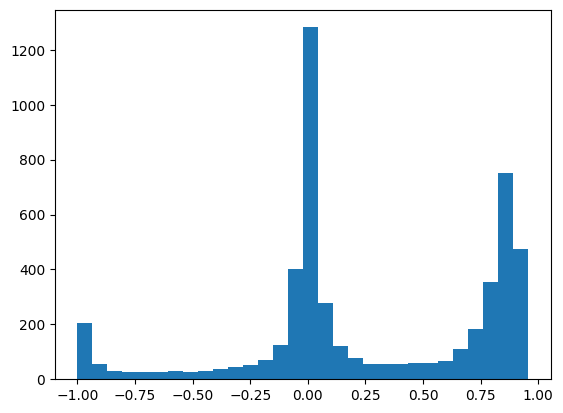

[I 2023-04-17 08:58:58,513] Trial 5 finished with value: 0.4714756247536998 and parameters: {'learning_rate': 6.477414550870838e-06, 'hidden_dropout_prob': 0.06345795818140704}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 6.67008744382395e-06,  
 hidden_dropout_prob 0.1518884278234905, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.415681,0.644733
262,No log,0.395064,0.628541
393,No log,0.376969,0.613978
524,0.426800,0.402564,0.634479
655,0.426800,0.249738,0.499738
786,0.426800,0.256003,0.505968
917,0.426800,0.235859,0.485654
1048,0.317000,0.246966,0.496957
1179,0.317000,0.308899,0.555787
1310,0.317000,0.263548,0.513370


evaluating model performance on validation set


validation loss 0.48420989699501804
making predictions on test set


count    5177.000000
mean        0.353504
std         0.460434
min        -1.000000
25%         0.025424
50%         0.295841
75%         0.800138
max         1.000000
Name: score, dtype: float64


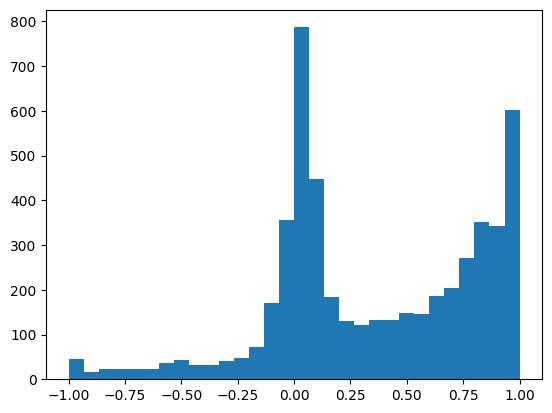

[I 2023-04-17 09:15:03,618] Trial 6 finished with value: 0.48420989699501804 and parameters: {'learning_rate': 6.67008744382395e-06, 'hidden_dropout_prob': 0.1518884278234905}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.611413206755279e-06,  
 hidden_dropout_prob 0.12308957924935286, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.422040,0.649646
262,No log,0.379078,0.615693
393,No log,0.312131,0.558687
524,0.411200,0.297040,0.545014
655,0.411200,0.231187,0.480819
786,0.411200,0.246515,0.496502
917,0.411200,0.234905,0.484670
1048,0.274200,0.248500,0.498498
1179,0.274200,0.257597,0.507540
1310,0.274200,0.224227,0.473526


evaluating model performance on validation set


validation loss 0.4685582820499703
making predictions on test set


count    5177.000000
mean        0.364623
std         0.481926
min        -0.957694
25%         0.020921
50%         0.209911
75%         0.887065
max         1.000000
Name: score, dtype: float64


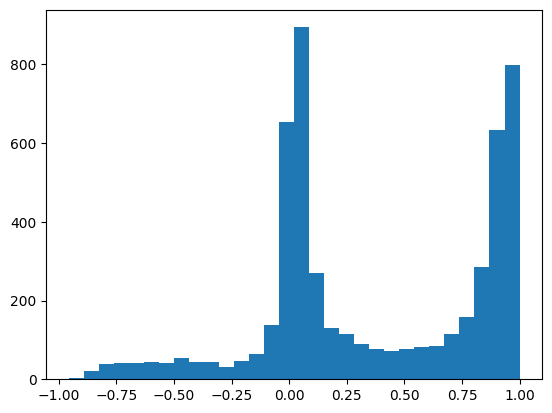

validation and test predictions are saved on google drive


[I 2023-04-17 09:35:13,041] Trial 7 finished with value: 0.4685582820499703 and parameters: {'learning_rate': 5.611413206755279e-06, 'hidden_dropout_prob': 0.12308957924935286}. Best is trial 0 with value: 0.4647692729685942.
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

hyperparameters are: learning_rate 6.396116249141026e-06,  
 hidden_dropout_prob 0.051283231742027625, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.418350,0.646800
262,No log,0.361243,0.601035
393,No log,0.278464,0.527697
524,0.379700,0.266044,0.515795
655,0.379700,0.252693,0.502686
786,0.379700,0.228759,0.478288
917,0.379700,0.236819,0.486641
1048,0.233300,0.245152,0.495128
1179,0.233300,0.272465,0.521982
1310,0.233300,0.251141,0.501140


evaluating model performance on validation set


validation loss 0.4781016314211928
making predictions on test set


count    5177.000000
mean        0.358011
std         0.450985
min        -0.931697
25%         0.068449
50%         0.214147
75%         0.828236
max         1.000000
Name: score, dtype: float64


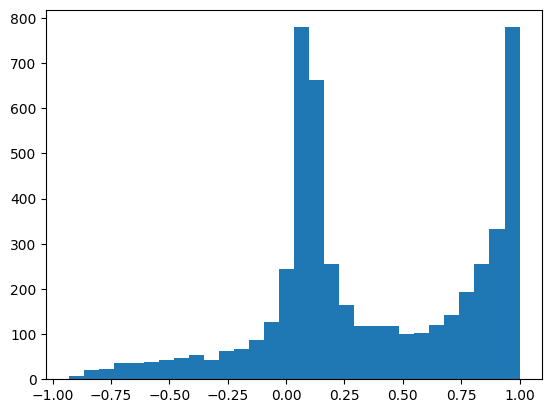

[I 2023-04-17 09:50:33,992] Trial 8 finished with value: 0.4781016314211928 and parameters: {'learning_rate': 6.396116249141026e-06, 'hidden_dropout_prob': 0.051283231742027625}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.6411601081573686e-06,  
 hidden_dropout_prob 0.21560981652997535, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.422043,0.649648
262,No log,0.418376,0.646820
393,No log,0.405592,0.636861
524,0.459700,0.596917,0.772604
655,0.459700,0.349678,0.591336
786,0.459700,0.348771,0.590568
917,0.459700,0.356256,0.596872
1048,0.422500,0.329111,0.573682
1179,0.422500,0.296430,0.544454
1310,0.422500,0.324414,0.569574


evaluating model performance on validation set


validation loss 0.4687136395618053
making predictions on test set


count    5177.000000
mean        0.272088
std         0.487776
min        -1.000000
25%         0.013448
50%         0.181316
75%         0.760916
max         0.898445
Name: score, dtype: float64


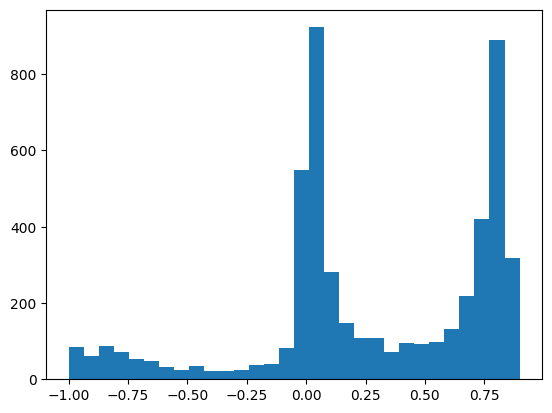

[I 2023-04-17 10:24:32,653] Trial 9 finished with value: 0.4687136395618053 and parameters: {'learning_rate': 5.6411601081573686e-06, 'hidden_dropout_prob': 0.21560981652997535}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 4.122030649673711e-06,  
 hidden_dropout_prob 0.08596085668306667, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.415241,0.644392
262,No log,0.379271,0.615850
393,No log,0.297819,0.545728
524,0.392200,0.288379,0.537009
655,0.392200,0.251870,0.501867
786,0.392200,0.239779,0.489672
917,0.392200,0.235497,0.485280
1048,0.270200,0.259141,0.509059
1179,0.270200,0.280899,0.529999
1310,0.270200,0.239261,0.489143


evaluating model performance on validation set


validation loss 0.4781935051561222
making predictions on test set


count    5177.000000
mean        0.387957
std         0.467916
min        -1.000000
25%         0.073485
50%         0.266456
75%         0.879609
max         1.000000
Name: score, dtype: float64


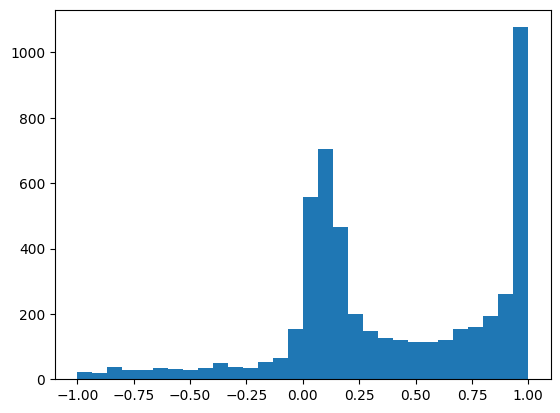

[I 2023-04-17 10:43:12,836] Trial 10 finished with value: 0.4781935051561222 and parameters: {'learning_rate': 4.122030649673711e-06, 'hidden_dropout_prob': 0.08596085668306667}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.380990053715954e-06,  
 hidden_dropout_prob 0.12488035688496953, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.426849,0.653337
262,No log,0.378916,0.615562
393,No log,0.369901,0.608195
524,0.493600,0.410755,0.640901
655,0.493600,0.327986,0.572700
786,0.493600,0.291902,0.540279
917,0.493600,0.272071,0.521604
1048,0.352900,0.243418,0.493374
1179,0.352900,0.227210,0.476665
1310,0.352900,0.222355,0.471545


evaluating model performance on validation set


validation loss 0.4706562417873259
making predictions on test set


count    5177.000000
mean        0.327892
std         0.438248
min        -1.000000
25%         0.042134
50%         0.205750
75%         0.757592
max         1.000000
Name: score, dtype: float64


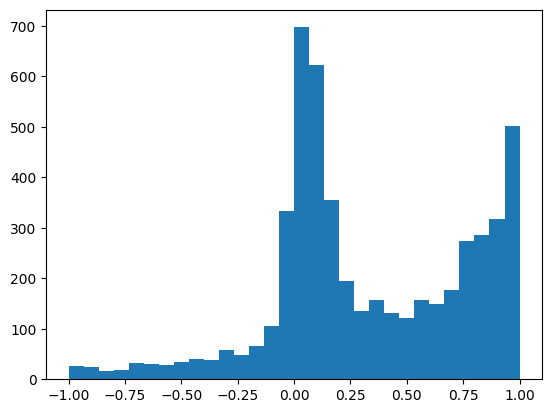

[I 2023-04-17 11:01:08,712] Trial 11 finished with value: 0.4706562417873259 and parameters: {'learning_rate': 5.380990053715954e-06, 'hidden_dropout_prob': 0.12488035688496953}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 4.5083074250359056e-06,  
 hidden_dropout_prob 0.13761146353036355, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.417340,0.646019
262,No log,0.404101,0.635690
393,No log,0.350263,0.591830
524,0.428300,0.350868,0.592341
655,0.428300,0.307578,0.554597
786,0.428300,0.285028,0.533880
917,0.428300,0.260355,0.510250
1048,0.314700,0.250951,0.500951
1179,0.314700,0.237620,0.487463


Step,Training Loss,Validation Loss,Mse
131,No log,0.417340,0.646019
262,No log,0.404101,0.635690
393,No log,0.350263,0.591830
524,0.428300,0.350868,0.592341
655,0.428300,0.307578,0.554597
786,0.428300,0.285028,0.533880
917,0.428300,0.260355,0.510250
1048,0.314700,0.250951,0.500951
1179,0.314700,0.237620,0.487463
1310,0.314700,0.227832,0.477317


evaluating model performance on validation set


validation loss 0.47514644580459686
making predictions on test set


count    5177.000000
mean        0.348934
std         0.454944
min        -1.000000
25%         0.032108
50%         0.206644
75%         0.819493
max         1.000000
Name: score, dtype: float64


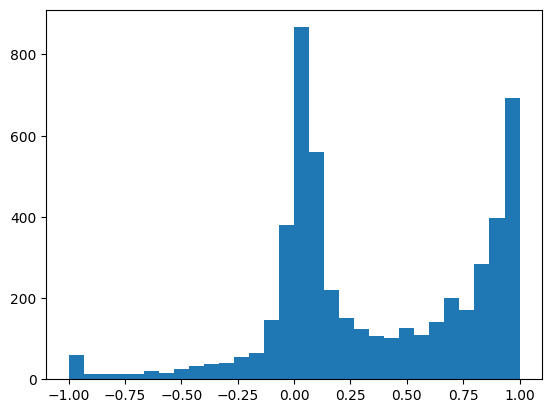

[I 2023-04-17 11:19:05,158] Trial 12 finished with value: 0.47514644580459686 and parameters: {'learning_rate': 4.5083074250359056e-06, 'hidden_dropout_prob': 0.13761146353036355}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.688251192297655e-06,  
 hidden_dropout_prob 0.08832892106672513, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.414306,0.643666
262,No log,0.383090,0.618943
393,No log,0.341688,0.584541
524,0.405300,0.372289,0.610155
655,0.405300,0.243823,0.493784
786,0.405300,0.235748,0.485539
917,0.405300,0.235584,0.485370
1048,0.280100,0.254374,0.504355
1179,0.280100,0.232405,0.482084
1310,0.280100,0.223769,0.473043


evaluating model performance on validation set


validation loss 0.46823919195081853
making predictions on test set


count    5177.000000
mean        0.305862
std         0.466710
min        -1.000000
25%         0.001303
50%         0.143913
75%         0.821724
max         1.000000
Name: score, dtype: float64


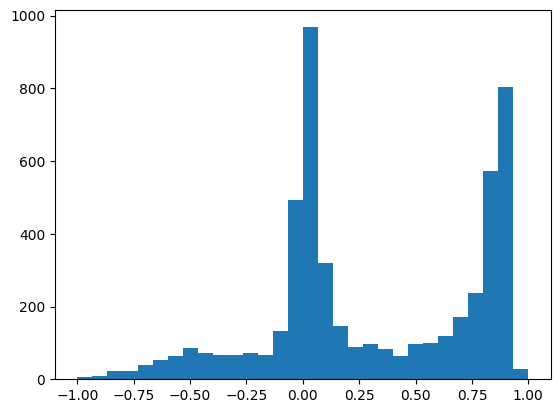

[I 2023-04-17 11:38:56,776] Trial 13 finished with value: 0.46823919195081853 and parameters: {'learning_rate': 5.688251192297655e-06, 'hidden_dropout_prob': 0.08832892106672513}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 7.639414382334289e-06,  
 hidden_dropout_prob 0.08960525312761941, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.415232,0.644385
262,No log,0.372012,0.609928
393,No log,0.299972,0.547697
524,0.395000,0.302580,0.550073
655,0.395000,0.234748,0.484508
786,0.395000,0.232790,0.482483
917,0.395000,0.237161,0.486992
1048,0.267200,0.299667,0.547419
1179,0.267200,0.267854,0.517546
1310,0.267200,0.280772,0.529879


evaluating model performance on validation set


validation loss 0.47997633241480425
making predictions on test set


count    5177.000000
mean        0.382316
std         0.493803
min        -1.000000
25%         0.039502
50%         0.255176
75%         0.925080
max         1.000000
Name: score, dtype: float64


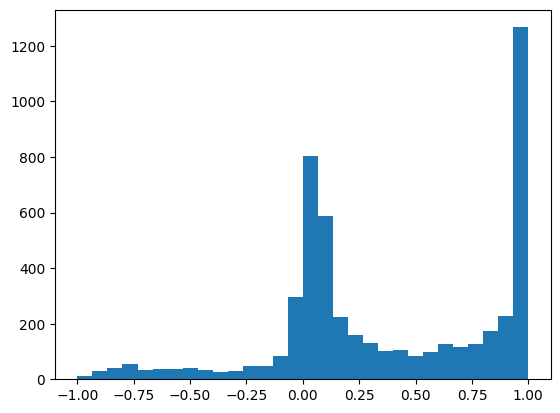

[I 2023-04-17 11:57:31,569] Trial 14 finished with value: 0.47997633241480425 and parameters: {'learning_rate': 7.639414382334289e-06, 'hidden_dropout_prob': 0.08960525312761941}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 9.726216625230538e-06,  
 hidden_dropout_prob 0.08890309929087424, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.408794,0.639370
262,No log,0.325541,0.570562
393,No log,0.261330,0.511204
524,0.429800,0.287698,0.536375
655,0.429800,0.253496,0.503484
786,0.429800,0.231559,0.481206
917,0.429800,0.226962,0.476405
1048,0.257500,0.217992,0.466896
1179,0.257500,0.307115,0.554179
1310,0.257500,0.236149,0.485952


evaluating model performance on validation set


validation loss 0.466107950089924
making predictions on test set


count    5177.000000
mean        0.314427
std         0.526735
min        -1.000000
25%        -0.010439
50%         0.189481
75%         0.849571
max         1.000000
Name: score, dtype: float64


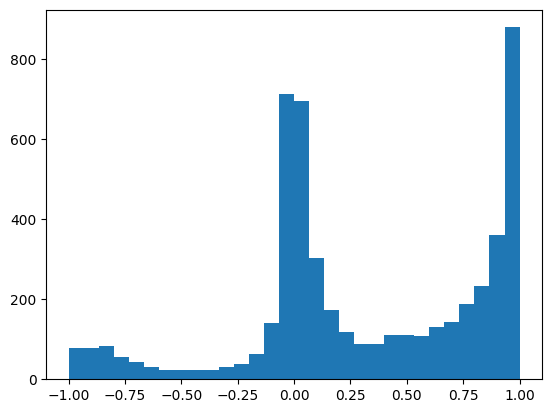

[I 2023-04-17 12:14:06,538] Trial 15 finished with value: 0.466107950089924 and parameters: {'learning_rate': 9.726216625230538e-06, 'hidden_dropout_prob': 0.08890309929087424}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 9.968733557011772e-06,  
 hidden_dropout_prob 0.07243934609709515, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.426148,0.652800
262,No log,0.360233,0.600194
393,No log,0.272929,0.522426
524,0.387700,0.261324,0.511198
655,0.387700,0.325454,0.570486
786,0.387700,0.238564,0.488430
917,0.387700,0.247515,0.497509
1048,0.245700,0.256982,0.506934
1179,0.245700,0.241441,0.491367
1310,0.245700,0.280305,0.529438


evaluating model performance on validation set


validation loss 0.47482386333601745
making predictions on test set


count    5177.000000
mean        0.321070
std         0.471887
min        -0.931236
25%         0.039551
50%         0.167041
75%         0.822605
max         1.000000
Name: score, dtype: float64


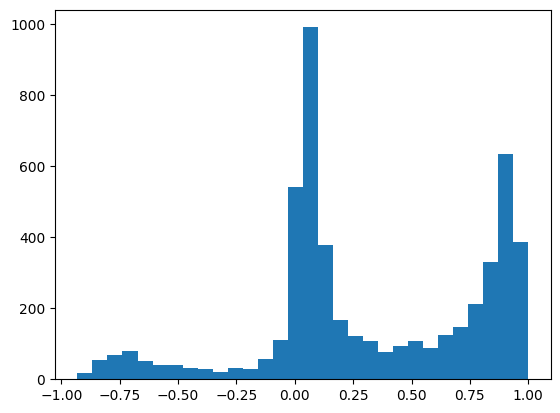

[I 2023-04-17 12:32:49,151] Trial 16 finished with value: 0.47482386333601745 and parameters: {'learning_rate': 9.968733557011772e-06, 'hidden_dropout_prob': 0.07243934609709515}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 9.937562254161952e-06,  
 hidden_dropout_prob 0.10257368480968779, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.415380,0.644500
262,No log,0.326962,0.571806
393,No log,0.315216,0.561441
524,0.437000,0.320834,0.566422
655,0.437000,0.238964,0.488839
786,0.437000,0.228849,0.478381
917,0.437000,0.234522,0.484275
1048,0.267600,0.246486,0.496474
1179,0.267600,0.290418,0.538905
1310,0.267600,0.262095,0.511952


evaluating model performance on validation set


validation loss 0.4779370885673096
making predictions on test set


count    5177.000000
mean        0.365123
std         0.454652
min        -1.000000
25%         0.039930
50%         0.270726
75%         0.822621
max         1.000000
Name: score, dtype: float64


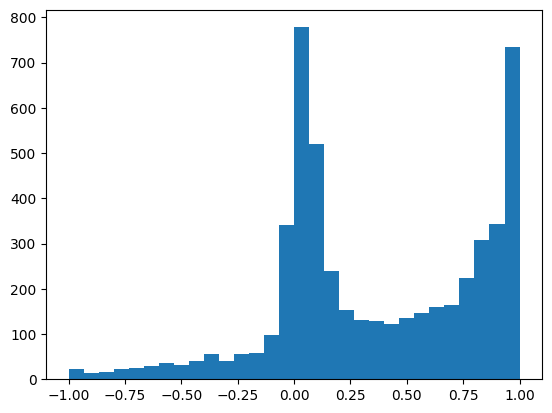

[I 2023-04-17 12:48:02,508] Trial 17 finished with value: 0.4779370885673096 and parameters: {'learning_rate': 9.937562254161952e-06, 'hidden_dropout_prob': 0.10257368480968779}. Best is trial 0 with value: 0.4647692729685942.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 8.107658640756605e-06,  
 hidden_dropout_prob 0.0509082157218903, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.416146,0.645094
262,No log,0.374302,0.611802
393,No log,0.287785,0.536456
524,0.382300,0.322260,0.567679
655,0.382300,0.240215,0.490117
786,0.382300,0.227503,0.476972
917,0.382300,0.223073,0.472306
1048,0.241800,0.234189,0.483930
1179,0.241800,0.248477,0.498474
1310,0.241800,0.225061,0.474406


evaluating model performance on validation set


validation loss 0.46414905230711667
making predictions on test set


count    5177.000000
mean        0.301015
std         0.527573
min        -1.000000
25%        -0.006648
50%         0.055422
75%         0.926314
max         1.000000
Name: score, dtype: float64


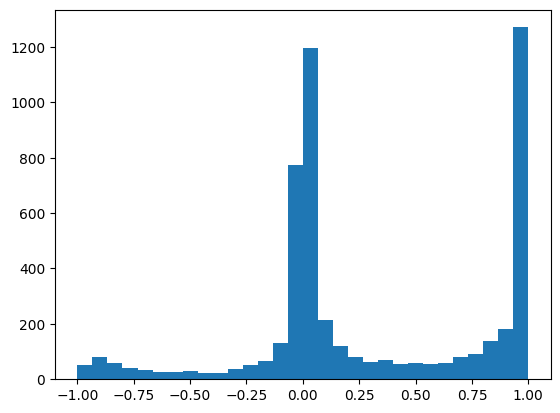

validation and test predictions are saved on google drive


[I 2023-04-17 13:08:01,986] Trial 18 finished with value: 0.46414905230711667 and parameters: {'learning_rate': 8.107658640756605e-06, 'hidden_dropout_prob': 0.0509082157218903}. Best is trial 18 with value: 0.46414905230711667.
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificatio

hyperparameters are: learning_rate 7.278571883730905e-06,  
 hidden_dropout_prob 0.05594041624937925, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.415593,0.644665
262,No log,0.357335,0.597775
393,No log,0.269345,0.518985
524,0.376500,0.258009,0.507946
655,0.376500,0.249320,0.499319
786,0.376500,0.229334,0.478888
917,0.376500,0.238542,0.488407
1048,0.236000,0.285421,0.534248
1179,0.236000,0.269561,0.519193
1310,0.236000,0.281352,0.530427


evaluating model performance on validation set


validation loss 0.47886556638817707
making predictions on test set


count    5177.000000
mean        0.306049
std         0.429022
min        -0.840261
25%         0.024302
50%         0.141723
75%         0.758385
max         1.000000
Name: score, dtype: float64


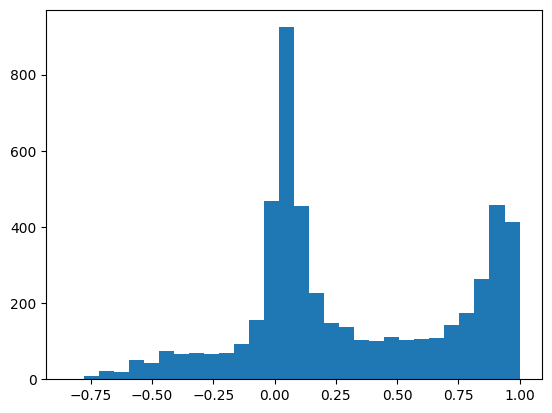

[I 2023-04-17 13:23:13,202] Trial 19 finished with value: 0.47886556638817707 and parameters: {'learning_rate': 7.278571883730905e-06, 'hidden_dropout_prob': 0.05594041624937925}. Best is trial 18 with value: 0.46414905230711667.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 6.0830357135962336e-06,  
 hidden_dropout_prob 0.0672558864602257, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.416299,0.645212
262,No log,0.397654,0.630598
393,No log,0.319993,0.565679
524,0.394600,0.282336,0.531353
655,0.394600,0.261039,0.510920
786,0.394600,0.239925,0.489821
917,0.394600,0.222134,0.471311
1048,0.254900,0.242762,0.492709
1179,0.254900,0.231530,0.481175
1310,0.254900,0.235104,0.484876


evaluating model performance on validation set


validation loss 0.4633079277951
making predictions on test set


count    5177.000000
mean        0.332505
std         0.519312
min        -1.000000
25%         0.023846
50%         0.177907
75%         0.884681
max         1.000000
Name: score, dtype: float64


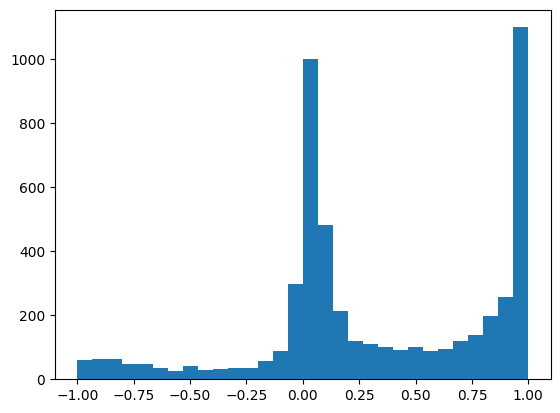

[I 2023-04-17 13:41:52,059] Trial 20 finished with value: 0.4633079277951 and parameters: {'learning_rate': 6.0830357135962336e-06, 'hidden_dropout_prob': 0.0672558864602257}. Best is trial 20 with value: 0.4633079277951.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 6.097421251500219e-06,  
 hidden_dropout_prob 0.06951018812701396, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.423173,0.650518
262,No log,0.372908,0.610662
393,No log,0.308910,0.555797
524,0.438800,0.270641,0.520232
655,0.438800,0.228417,0.477930
786,0.438800,0.226934,0.476376
917,0.438800,0.240679,0.490590
1048,0.253100,0.239691,0.489582
1179,0.253100,0.303013,0.550466
1310,0.253100,0.245452,0.495431


evaluating model performance on validation set


validation loss 0.47589488725514584
making predictions on test set


count    5177.000000
mean        0.334276
std         0.522401
min        -0.920444
25%        -0.006964
50%         0.171052
75%         0.906977
max         1.000000
Name: score, dtype: float64


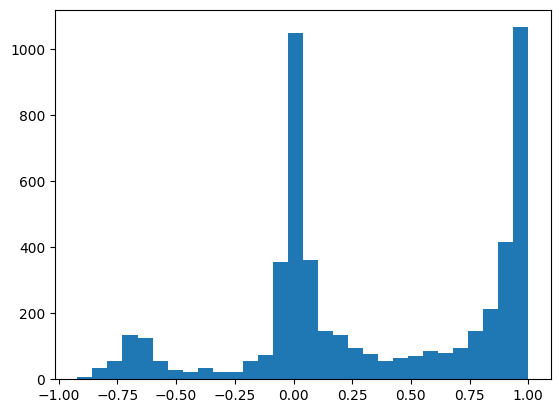

[I 2023-04-17 14:02:28,410] Trial 21 finished with value: 0.47589488725514584 and parameters: {'learning_rate': 6.097421251500219e-06, 'hidden_dropout_prob': 0.06951018812701396}. Best is trial 20 with value: 0.4633079277951.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 5.998246494438883e-06,  
 hidden_dropout_prob 0.052395242416855704, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.422371,0.649900
262,No log,0.340608,0.583616
393,No log,0.258612,0.508540
524,0.370800,0.258362,0.508293
655,0.370800,0.244270,0.494236
786,0.370800,0.228398,0.477910
917,0.370800,0.253210,0.503200
1048,0.232400,0.241977,0.491912
1179,0.232400,0.271894,0.521434
1310,0.232400,0.252242,0.502237


evaluating model performance on validation set


validation loss 0.4769465858867387
making predictions on test set


count    5177.000000
mean        0.344201
std         0.471707
min        -1.000000
25%         0.075568
50%         0.232771
75%         0.800089
max         1.000000
Name: score, dtype: float64


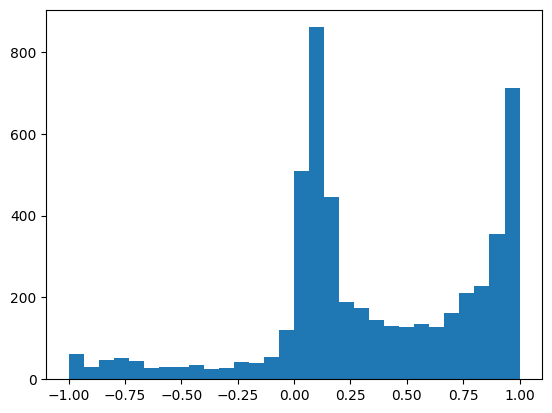

validation and test predictions are saved on google drive


[I 2023-04-17 14:17:42,165] Trial 22 finished with value: 0.4769465858867387 and parameters: {'learning_rate': 5.998246494438883e-06, 'hidden_dropout_prob': 0.052395242416855704}. Best is trial 20 with value: 0.4633079277951.
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

hyperparameters are: learning_rate 7.498216025911506e-06,  
 hidden_dropout_prob 0.07141713996256321, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.417606,0.646224
262,No log,0.377447,0.614367
393,No log,0.291429,0.539841
524,0.390100,0.343941,0.586465
655,0.390100,0.246130,0.496115
786,0.390100,0.249302,0.499301
917,0.390100,0.236205,0.486009
1048,0.250500,0.252318,0.502312
1179,0.250500,0.261682,0.511549
1310,0.250500,0.253546,0.503533


evaluating model performance on validation set


validation loss 0.48011923156070024
making predictions on test set


count    5177.000000
mean        0.343198
std         0.545816
min        -1.000000
25%        -0.000537
50%         0.123101
75%         0.966712
max         1.000000
Name: score, dtype: float64


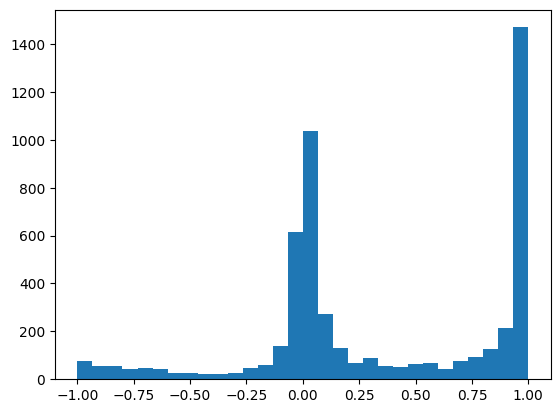

[I 2023-04-17 14:37:39,558] Trial 23 finished with value: 0.48011923156070024 and parameters: {'learning_rate': 7.498216025911506e-06, 'hidden_dropout_prob': 0.07141713996256321}. Best is trial 20 with value: 0.4633079277951.


validation and test predictions are saved on google drive


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

hyperparameters are: learning_rate 6.2037637707348336e-06,  
 hidden_dropout_prob 0.050267230663545645, 
 batch_size 16


Step,Training Loss,Validation Loss,Mse
131,No log,0.418780,0.647132
262,No log,0.389778,0.624322
393,No log,0.272685,0.522192
524,0.375600,0.270581,0.520174
655,0.375600,0.226641,0.476068
786,0.375600,0.217195,0.466042
917,0.375600,0.226084,0.475483
1048,0.236200,0.242520,0.492464
1179,0.236200,0.238436,0.488299
1310,0.236200,0.241955,0.491889


evaluating model performance on validation set


validation loss 0.46267007322149756
making predictions on test set


count    5177.000000
mean        0.319347
std         0.576116
min        -1.000000
25%        -0.007079
50%         0.126525
75%         0.973274
max         1.000000
Name: score, dtype: float64


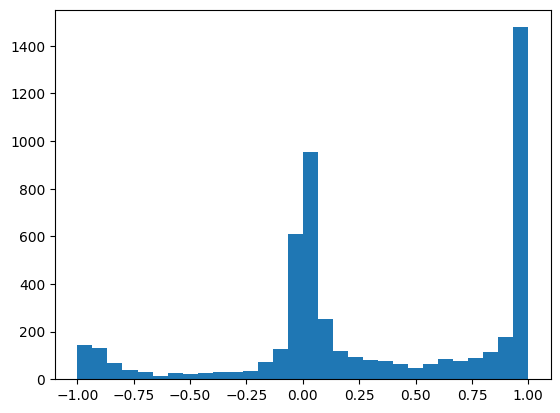

[I 2023-04-17 14:58:18,564] Trial 24 finished with value: 0.46267007322149756 and parameters: {'learning_rate': 6.2037637707348336e-06, 'hidden_dropout_prob': 0.050267230663545645}. Best is trial 24 with value: 0.46267007322149756.


validation and test predictions are saved on google drive


In [51]:
study.optimize(func=objective, n_trials=25)

In [52]:
print(study.best_value)
print(study.best_params)
print(study.best_trial)

0.46267007322149756
{'learning_rate': 6.2037637707348336e-06, 'hidden_dropout_prob': 0.050267230663545645}
FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.46267007322149756], datetime_start=datetime.datetime(2023, 4, 17, 14, 37, 39, 559542), datetime_complete=datetime.datetime(2023, 4, 17, 14, 58, 18, 564534), params={'learning_rate': 6.2037637707348336e-06, 'hidden_dropout_prob': 0.050267230663545645}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1e-05, log=True, low=4e-06, step=None), 'hidden_dropout_prob': FloatDistribution(high=0.22, log=False, low=0.05, step=None)}, trial_id=24, value=None)


In [53]:
best_params = study.best_params
best_params

{'learning_rate': 6.2037637707348336e-06,
 'hidden_dropout_prob': 0.050267230663545645}

In [ ]:
from google.colab import runtime
runtime.unassign()